# 前期准备工作

## 在windows上安装Ubuntu-22.04（使用triton需要使用在linux上运行）

由于triton在windows没有可用的版本，考虑到大家都是使用的windows系统的比较多，这里附一个安装教程，有linux系统或者不想运行triton模块的同学可以跳过，
整个作业使用**linux**进行，读者可以使用**windows的wsl**来在windows中跑通作本次作业是关于GPU和分布式训练的，如果有多个GPU就可以跑通，只有一个GPU也可以，但是就没有分布式训练的速度优势，但是作为教学学习是足够的。

如果您想使用自己作业1的实现，请将`cs336-basics`目录替换为您自己的实现，或编辑外层`pyproject.toml`文件以指向您自己的实现

### 安装步骤

#### 1. 版本限制

我们需要在windows上安装wsl2，限制在Windows 10 2004 (19041) 及以上 或者 Windows 11 任意版本

#### 2.手动启用 WSL 相关功能（关键）

按住win键搜索**启用或者关闭windows功能**，找到并勾选 **于Linux的Windows子系统**和 **虚拟机平台**，点击确定


#### 3. 确认 CPU 虚拟化已开启

按住Ctrl + Shift + Esc打开任务管理器，性能 -> CPU ，右侧应显示：虚拟化：已启用

如果是“未启用”

需要进 BIOS / UEFI，开启：

Intel：Intel Virtualization Technology (VT-x)

AMD：SVM Mode

##### 4. 安装 Ubuntu

在windows搜索页面中输入CMD，并且以**管理员身份**运行

```bash
wsl --install -d Ubuntu
```

之后设置账号密码，密码在输入的时候是不可见的，看不到是正常的

要打开ubuntu的命令行只需要在CMD命令行中输入
```bash
wsl
```

##### 5. 安装相关的工具 pip uv 等

依次执行
先使用管理员身份打开CMD

输入
```bash

cd $env:USERPROFILE
@"
[wsl2]
networkingMode=mirrored
dnsTunneling=true
autoProxy=true
firewall=true
"@ | Out-File -Encoding UTF8 .wslconfig


wsl --shutdown     # 彻底关掉虚拟机
wsl                # 再进子系统
```

```bash

sudo apt update
sudo apt install python3-pip

sudo apt install python3.12-venv

source ~/myenv/bin/activate
pip install uv -i https://pypi.tuna.tsinghua.edu.cn/simple
sudo ln -s /home/kangkang/myenv/bin/uv /usr/local/bin/uv

echo 'export UV_INDEX_URL=https://pypi.tuna.tsinghua.edu.cn/simple' >> ~/.bashrc

source ~/.bashrc



```

#### 6. 设置vscode的远程连接

打开vscode ，先搜索插件wsl。安装完成后打开左侧一列的远程连接就可以连接到wsl的ubuntu系统中


运行在CS336-Chinese-co-construction\coursework\Assignment2_System下
```bash
cd CS336-Chinese-co-construction\coursework\Assignment2_System
uv sync
uv run
```



# 1. 基准测试和性能分析

# 作业一

（a）编写一个脚本，对模型的前向与反向传播进行基本的端到端基准测试。具体而言，你的脚本应支持以下功能：
- 给定超参数（例如层数），初始化一个模型。
- 生成一个随机批次的数据。
- 先运行 w 个预热步骤（开始计时之前），然后计时执行 n 个步骤（仅前向或同时包含前向与反向，取决于参数）。计时可使用 Python 的 timeit 模块（例如直接调用 timeit 函数，或使用 timeit.default_timer()，后者提供系统最高分辨率的时钟，比 time.time() 更适合基准测试）。
- 每一步之后调用 torch.cuda.synchronize()。

交付物：一个脚本，能够根据给定超参数初始化基础 Transformer 模型，创建随机数据批次，并对前向与反向传播进行计时。

（b）对 §1.2 中描述的模型规模，分别测试前向与反向传播耗时。  
使用 5 个预热步骤，并在 10 次测量步骤上计算平均耗时与标准差。  
一次前向传播耗时多久？反向传播呢？测量结果波动大吗，还是标准差很小？  

交付物：1–2 句话给出你的计时结果。

（c）基准测试的一个常见陷阱是跳过预热步骤。请在没有预热的情况下重复上述分析。结果如何变化？你认为原因是什么？再尝试仅使用 1 或 2 个预热步骤，为何结果仍可能不同？

## 首先检查GPU是否可用

这边通过pyproject.toml下载的torch是cpu版本
如果要安装GPU版本：
```bash
uv pip uninstall torch 
uv pip install torch --index-url https://download.pytorch.org/whl/cu121
```
cu121是我的cuda版本为12.1，可以改为自己的cuda版本

In [4]:
from cs336_basics.model import BasicsTransformerLM 
from cs336_basics.optimizer import get_cosine_lr
from cs336_basics.optimizer import AdamW
from cs336_basics.data import get_batch

In [ ]:
import torch
import time
from typing import Callable
import time
import torch.nn.functional as F



print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("No CUDA GPU detected")

print("MPS（苹果的MPS） available:", hasattr(torch.backends, "mps") and torch.backends.mps.is_available())


Torch version: 2.9.1+cu128
CUDA available: True
CUDA device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4060 Laptop GPU
MPS（苹果的MPS） available: False


In [6]:
def mean(values: list[float]) -> float:
    if not values:
        raise ValueError("mean() requires at least one value")
    return sum(values) / len(values)

def benchmark(description: str, run: Callable, num_warmups: int = 1, num_trials: int = 3):
    """Benchmark `func` by running it `num_trials`, and return all the times."""
    # 热身：第一次运行可能较慢,因为要编译和缓存
    # 我们将多次要运行内核，因为重要的是稳态的运行时间。
    for _ in range(num_warmups):
        run()
    if torch.cuda.is_available():
        torch.cuda.synchronize()  # 等待 CUDA 线程完成（非常重要！）
    print('现在真正计时!')
    times: list[float] = [] # @inspect times, @inspect description

    for trial in range(num_trials):  # 多次重复
        start_time = time.time()
        run()  # 实际执行计算
        if torch.cuda.is_available():
            torch.cuda.synchronize()  # 等待 CUDA 线程 完成同步
        end_time = time.time()
        times.append((end_time - start_time) * 1000) # @inspect times
    mean_time = mean(times) # 多次测量取平均

    print(f'单次耗时：{mean_time  }ms')
    return mean_time 

现在来测试一下sleep函数


In [7]:
benchmark("sleep", lambda : time.sleep(50 / 1000))

现在真正计时!
单次耗时：50.19839604695638ms


50.19839604695638

在误差范围之内

我们来实测一下transformer

In [8]:
min_lr = 3e-5
warmup_iters = 200
cosine_cycle_iters = 10_000
num_steps = 10
batch_size = 32

In [9]:
import numpy as np 
import gc
def test_transformer():

    vocab_size = 50_000
    context_length = 128
    d_model = 512
    num_layers = 6
    num_heads = 8
    d_ff = 2048
    rope_theta = 10000.0
    max_lr = 3e-4
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = BasicsTransformerLM(
        vocab_size=vocab_size,
        context_length=context_length,
        d_model=d_model,
        num_layers=num_layers,
        num_heads=num_heads,
        d_ff=d_ff,
        rope_theta=rope_theta,
    ).to(device)

    optimizer = AdamW(
        model.parameters(),
        lr=max_lr,
        weight_decay=0.1,
    )

    # 假设是 token 序列
    dataset = np.arange(1000, dtype=np.int64)
    x, y = get_batch(
        dataset=dataset,
        batch_size=4,
        context_length=8,
        device="cuda"
    )

    print(x.shape)  # (4, 8)
    print(y.shape)  # (4, 8)
    print(x)
    print(y)


    model.train()
    model(x)
    print(f'设备：{device}')
    #  清理显存引用
    try:
        del model, x,y, optimizer,dataset
    except NameError:
        pass
    torch.cuda.empty_cache()
    gc.collect()
test_transformer()

torch.Size([4, 8])
torch.Size([4, 8])
tensor([[184, 185, 186, 187, 188, 189, 190, 191],
        [130, 131, 132, 133, 134, 135, 136, 137],
        [360, 361, 362, 363, 364, 365, 366, 367],
        [683, 684, 685, 686, 687, 688, 689, 690]], device='cuda:0')
tensor([[185, 186, 187, 188, 189, 190, 191, 192],
        [131, 132, 133, 134, 135, 136, 137, 138],
        [361, 362, 363, 364, 365, 366, 367, 368],
        [684, 685, 686, 687, 688, 689, 690, 691]], device='cuda:0')
设备：cuda


In [10]:
import numpy  as np
def lm_loss(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # logits: (B, T, V)
        # targets: (B, T)
        B, T, V = logits.shape
        return F.cross_entropy(
            logits.view(B * T, V),
            targets.view(B * T),
        )
def run_model(num_steps = 1):
    min_lr = 3e-5
    warmup_iters = 200
    cosine_cycle_iters = 10_000
    num_steps = 10
    batch_size = 32
    vocab_size = 50_000
    context_length = 128
    d_model = 512
    num_layers = 6
    num_heads = 8
    d_ff = 2048
    rope_theta = 10000.0
    min_lr = 3e-5
    max_lr = 3e-4
    device = "cuda" if torch.cuda.is_available() else "cpu"
    for it in range(num_steps):
        print(f'{it}/{num_steps}')
        dataset = np.arange(1000, dtype=np.int64)
    

        model = BasicsTransformerLM(
                                vocab_size=vocab_size,
                                context_length=context_length,
                                d_model=d_model,
                                num_layers=num_layers,
                                num_heads=num_heads,
                                d_ff=d_ff,
                                rope_theta=rope_theta,
                                ).to(device)
        optimizer = AdamW(
                            model.parameters(),
                            lr=max_lr,
                            weight_decay=0.1,
                        )
        # 1️更新学习率（每 step）
        lr = get_cosine_lr(
            it=it,
            max_learning_rate=max_lr,
            min_learning_rate=min_lr,
            warmup_iters=warmup_iters,
            cosine_cycle_iters=cosine_cycle_iters,
        )
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        # 2取 batch
        x, y = get_batch(
            dataset=dataset,
            batch_size=batch_size,
            context_length=context_length,
            device=device,
        )
        # print(x)

        # 3前向
        logits = model(x)

        # 4loss
        loss = lm_loss(logits, y)

        # 5反向
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        
        # （可选）梯度裁剪（强烈推荐）
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 6更新参数
        optimizer.step()

    # 7日志
    if it % 10 == 0:
        print(
            f"step {it:6d} | "
            f"loss {loss.item():.4f} | "
            f"lr {lr:.2e}"
        )

    #  清理显存引用
    try:
        del model, x, y, logits, loss, lr, optimizer
    except NameError:
        pass
    torch.cuda.empty_cache()
    gc.collect()
benchmark(description = 'transformer模型的基准测试', run =  run_model, num_warmups = 1, num_trials = 10)

0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
现在真正计时!
0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
单次耗时：7469.104385375977ms


7469.104385375977

## 推理：

In [ ]:
def generate():
    vocab_size = 50_000
    context_length = 128
    d_model = 512
    num_layers = 6
    num_heads = 8
    d_ff = 2048
    rope_theta = 10000.0
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = BasicsTransformerLM(
                            vocab_size=vocab_size,
                            context_length=context_length,
                            d_model=d_model,
                            num_layers=num_layers,
                            num_heads=num_heads,
                            d_ff=d_ff,
                            rope_theta=rope_theta,
                            ).to(device)

    model.eval()

    with torch.no_grad():
        # 用 get_batch 拿一个 batch
        dataset = np.arange(1000, dtype=np.int64)
        x, _ = get_batch(
            dataset=dataset,
            batch_size=1,
            context_length= 1,
            device=device,
        )

        # 取第一个样本作为 prompt
        prompt = x # shape: (context_length,)
        # 调用模型自带的 generate
        generated = model.generate(
            x=prompt,
            max_new_tokens=5,
            temperature=1.0,
            top_k=50,
            eos_token_id=None,
        )

        print(generated.shape)  # (<=50,)
        print(generated)
        try:
            del model, x, prompt, generated, dataset
        except NameError:
            pass
        torch.cuda.empty_cache()
        gc.collect()

### 性能分析工具

使用wsl后无法测量cuda时间，这是正常现象，可以使用正常的linux系统或者windows系统，原因在于wsl的linux无法使用torch的一些接口(CUPTI)来检测cuda

In [11]:
import torch, ctypes, os
print('torch:', torch.__version__)
print('cuda :', torch.version.cuda)
try:
    ctypes.CDLL('libcupti.so')
    print('CUPTI: OK')
except:
    print('CUPTI: NOT FOUND')

torch: 2.9.1+cu128
cuda : 12.8
CUPTI: NOT FOUND


In [12]:
from torch.profiler import ProfilerActivity
import os
def profile(description: str, run: Callable, num_warmups: int = 1, with_stack: bool = False):
    # 预热
    for _ in range(num_warmups):
        run()
    if torch.cuda.is_available():
        print("正在使用cuda")
        torch.cuda.synchronize()  # 等待CUDA线程结束
    else:
        print('正在使用cpu')
    # 使用性能分析器运行代码
    
    with torch.profiler.profile(
            activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
            # 输出堆栈跟踪以进行可视化
            with_stack=with_stack,
            #  需要导出堆栈跟踪以进行可视化
            experimental_config=torch._C._profiler._ExperimentalConfig(verbose=True)) as prof:
        run()
        if torch.cuda.is_available():
            torch.cuda.synchronize()  # 等待CUDA线程结束
    # 打印表格
    table = prof.key_averages().table(
        sort_by="self_cuda_time_total",
        max_name_column_width=80,
        row_limit=10,
        top_level_events_only=False) 
    #text(f"## {description}")
    #text(table, verbatim=True)
    # Write stack trace visualization
    if with_stack:
        os.makedirs("var", exist_ok=True)
        text_path = f"var/stacks_{description}.txt"
        svg_path = f"var/stacks_{description}.svg"
        prof.export_stacks(text_path, "self_cuda_time_total")
    return table

print(profile(description ='transformer' , run = run_model, num_warmups = 3, with_stack = True))

0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
正在使用cuda
0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
--------------------------------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
--------------------------------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                                       aten::bmm         0.58%      39.712ms         1.13

# 作业二

然而，简单地将模型转换为低精度格式可能会导致模型精度降低。例如，许多梯度值在实践中太小，无法用 FP16 表示，因此在用 FP16 精度进行简单训练时会变成零。为了解决这个问题，通常在用 FP16 训练时使用损失缩放（loss is simply multiplied by a scaling factor, increasing gradient magnitudes so they don't flush to zero）。此外，FP16 的动态范围比 FP32 低，这可能导致溢出，表现为 NaN 损失。全精度（Full bfloat16）训练通常更稳定（因为 BF16 具有与 FP32 相同的动态范围），但与 FP32 相比仍可能影响最终模型性能。

为了利用低精度数据类型的加速优势，通常使用混合精度训练。在 PyTorch 中，这通过 torch.autocast 上下文管理器实现。在这种情况下，某些操作（例如矩阵乘法）在低精度数据类型上执行，而需要 FP32 全动态范围的操作（例如累积和归约）保持不变。例如，以下代码将自动识别在前向传播期间需要在低精度上执行的操作，并将这些操作转换为指定的数据类型：

```python
model : torch.nn.Module = ...  # 例如，你的 Transformer 模型
dtype : torch.dtype = ...  # 例如，torch.float16
x : torch.Tensor = ...  # 输入数据

with torch.autocast(device="cuda", dtype=dtype):
    y = model(x)
```

如上所述，即使张量本身已被降级，通常最好在高精度下保持累积。以下练习将帮助你建立直觉，了解为什么会这样。

问题（混合精度累积）：1 分

运行以下代码并评论结果的准确性。

```python
s = torch.tensor(0, dtype=torch.float32)
for i in range(1000):
    s += torch.tensor(0.01, dtype=torch.float32)
print(s)

s = torch.tensor(0, dtype=torch.float16)
for i in range(1000):
    s += torch.tensor(0.01, dtype=torch.float16)
print(s)

s = torch.tensor(0, dtype=torch.float32)
for i in range(1000):
    s += torch.tensor(0.01, dtype=torch.float16)
print(s)

s = torch.tensor(0, dtype=torch.float32)
for i in range(1000):
    x = torch.tensor(0.01, dtype=torch.float16)
    s += x.type(torch.float32)
print(s)
```

交付物：2–3 句话的回应。

我们现在将混合精度应用于一个玩具模型进行直观理解，然后应用于我们的基准测试脚本。

In [2]:
import torch
import gc
s = torch.tensor(0, dtype=torch.float32)
for i in range(1000):
    s += torch.tensor(0.01, dtype=torch.float32)
print(s)

s = torch.tensor(0, dtype=torch.float16)
for i in range(1000):
    s += torch.tensor(0.01, dtype=torch.float16)
print(s)

s = torch.tensor(0, dtype=torch.float32)
for i in range(1000):
    s += torch.tensor(0.01, dtype=torch.float16)
print(s)

s = torch.tensor(0, dtype=torch.float32)
for i in range(1000):
    x = torch.tensor(0.01, dtype=torch.float16)
    s += x.type(torch.float32)
print(s)


#  清理显存引用
try:
    del s, x,i
except NameError:
    pass
torch.cuda.empty_cache()
gc.collect()

tensor(10.0001)
tensor(9.9531, dtype=torch.float16)
tensor(10.0021)
tensor(10.0021)


754

可以看到全精度最准确，半进度最不准确，混合精度介于二者之间

# 作业三

问题（benchmarking_mixed_precision）：2 分

（a）考虑以下模型：

```python
class ToyModel(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 10, bias=False)
        self.ln = nn.LayerNorm(10)
        self.fc2 = nn.Linear(10, out_features, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.ln(x)
        x = self.fc2(x)
        return x
```

假设我们在 GPU 上训练模型，并且模型参数最初是 FP32。我们希望使用 FP16 的自动混合精度。上述列出的每个组件的数据类型是什么？

- autocast 上下文内的模型参数，
- 第一个前馈层（ToyModel.fc1）的输出，
- 层归一化（ToyModel.ln）的输出，
- 模型的预测 logits，
- 损失，
- 以及模型的梯度？

交付物：上述列出的每个组件的数据类型。

（b）你应该已经看到，FP16 混合精度自动转换对层归一化层的处理与前馈层不同。层归一化的哪些部分对混合精度敏感？如果我们使用 BF16 而不是 FP16，是否仍需要对层归一化进行不同处理？为什么或为什么不？

交付物：2–3 句话的回应。

（c）修改你的基准测试脚本，以便可以选择使用 BF16 混合精度运行模型。对 §1.1.2 中描述的每种语言模型规模，分别计时使用和不使用混合精度的前向和反向传播。比较使用全精度与混合精度的结果，并评论模型大小变化时的任何趋势。你可能会发现无上下文的 no-op 上下文管理器很有用。

交付物：2–3 句话的回应，包含你的计时结果和评论。

# 解答


### 问题 (a)

在自动混合精度（Autocast）下，使用 FP16 训练时，各组件的数据类型如下：

- **模型参数（model parameters）**：由于模型参数最初是 FP32，它们在 autocast 上下文内保持为 FP32。
- **第一个前馈层的输出（output of the first feed-forward layerToyModel.fc1）**：在 autocast 上下文中，该层的输出将被转换为 FP16。
- **层归一化的输出（output of layer norm ToyModel.ln）**：层归一化层的输出通常保持为 FP32，因为层归一化需要较高的数值稳定性，FP16 的动态范围较小，可能导致数值不稳定。
- **模型的预测 logits**：在 autocast 上下文中，这些 logits 将被转换为 FP16。
- **损失（loss）**：损失计算通常在 FP32 中进行，以保持数值稳定性。
- **模型的梯度（model's gradients）**：梯度通常也保持为 FP32，以确保优化过程的稳定性。

### 问题 (b)

层归一化对混合精度的敏感性主要体现在其计算过程中需要较高的数值精度。层归一化涉及到均值和方差的计算，这些计算在 FP16 中可能会因为数值范围的限制而导致不准确，从而影响模型的训练效果。因此，即使在 FP16 混合精度下，层归一化通常也需要保持在 FP32 中进行，以确保数值稳定性。

如果我们使用 BF16 而不是 FP16，我们可能仍然需要对层归一化进行特殊处理。BF16 虽然在动态范围上与 FP32 相同，但其精度较低，可能仍然不足以保证层归一化计算的稳定性。因此，为了保持数值稳定性，层归一化可能仍然需要在 FP32 中进行。

### 问题 (c)

为了在基准测试脚本中使用 BF16 混合精度，我们可以修改脚本以支持 BF16。以下是修改后的脚本示例：

```python
import torch
import torch.nn as nn
import timeit

class ToyModel(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 10, bias=False)
        self.ln = nn.LayerNorm(10)
        self.fc2 = nn.Linear(10, out_features, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.ln(x)
        x = self.fc2(x)
        return x

# 模型初始化
model = ToyModel(100, 10)
x = torch.randn(1, 100)

# 使用 FP32 进行基准测试
with torch.no_grad():
    fp32_time = timeit.timeit(lambda: model(x), number=100)

# 使用 BF16 进行基准测试
with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
    with torch.no_grad():
        bf16_time = timeit.timeit(lambda: model(x), number=100)

print(f"FP32 time: {fp32_time}")
print(f"BF16 time: {bf16_time}")
```

在比较使用全精度（FP32）与混合精度（BF16）的结果时，我们可能会观察到 BF16 在某些情况下可以提供与 FP32 相似的精度，同时显著减少内存使用和加速计算。然而，对于需要高精度计算的层（如层归一化），BF16 可能不如 FP32 稳定。随着模型大小的变化，我们可能会看到不同规模的模型对混合精度的敏感性不同，这需要在实际应用中进行具体分析和调整。

In [1]:
import torch
import torch.nn as nn
import timeit
import gc
class ToyModel(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 10, bias=False)
        self.ln = nn.LayerNorm(10)
        self.fc2 = nn.Linear(10, out_features, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.ln(x)
        x = self.fc2(x)
        return x

def test_fb32_BF16_time():

    # 模型初始化，可以修改参数来测试效果
    model = ToyModel(100, 10)
    x = torch.randn(1, 100)



    # 使用 FP32 进行基准测试
    with torch.no_grad():
        fp32_time = timeit.timeit(lambda: model(x), number=100)

    # 使用 BF16 进行基准测试
    with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
        with torch.no_grad():
            bf16_time = timeit.timeit(lambda: model(x), number=100)

    #  清理显存引用



    print(f"FP32 time: {fp32_time}")
    print(f"BF16 time: {bf16_time}")
    try:
        del model, x, fp32_time, bf16_time
    except NameError:
        pass
    torch.cuda.empty_cache()
    gc.collect()

In [2]:
test_fb32_BF16_time()

FP32 time: 0.039825333005865104
BF16 time: 0.0021841169946128502


可以看到不同精度下，精度越低则速度越快

# 作业四


到目前为止，我们一直在关注计算性能。现在我们将把注意力转向**内存**，这是语言模型训练和推理中的另一项关键资源。
PyTorch 也提供了一个强大的**内存分析器（memory profiler）**，可以随时间跟踪内存分配情况。

要使用内存分析器，你可以按如下方式修改你的 benchmark 脚本：

```
7
```

---

```python
# ... 在你的 benchmarking 脚本中的 warm-up 阶段

# 开始记录内存历史
torch.cuda.memory._record_memory_history(max_entries=1000000)

# ... 在你的 benchmarking 脚本中你想要分析的部分

# 保存一个 pickle 文件，用于 PyTorch 的在线工具加载
torch.cuda.memory._dump_snapshot("memory_snapshot.pickle")

# 停止记录内存历史
torch.cuda.memory._record_memory_history(enabled=None)
```

这将输出一个名为 `memory_snapshot.pickle` 的文件，你可以将其加载到如下在线工具中：
[https://pytorch.org/memory_viz](https://pytorch.org/memory_viz)
该工具可以让你查看整体内存使用时间线，以及每一次独立的内存分配是如何发生的，包括其大小以及指向分配来源代码位置的调用栈追踪。

要使用该工具，你应当在浏览器中打开上述链接，然后将你的 pickle 文件拖拽到页面中。

现在你将使用 PyTorch profiler 来分析你模型的内存使用情况。

---

### Problem（memory profiling）：4 分

对 **表 1 中的 2.7B 模型**进行 profiling，分析其 **前向传播（forward pass）**、**反向传播（backward pass）** 以及 **优化器步骤（optimizer step）**，上下文长度分别为 **128、256 和 512**。

---

**(a)**
在你的 profiling 脚本中加入一个选项，使模型运行时能够经过内存分析器。
你可能需要复用之前的一些基础设施（例如：激活 mixed-precision、加载特定的模型大小等）。

然后，在以下两种情况下，为 2.7B 模型获取内存 profile：

* 只做推理（仅前向传播）
* 完整训练一步（前向 + 反向 + 优化器步骤）

你的内存时间线看起来如何？你能否根据看到的峰值判断当前运行的是哪个阶段？

**Deliverable：**
来自 `pytorch.org/memory_viz` 工具中 **“Active Memory Timeline”** 的两张截图（针对 context length = 512）：

* 一张是仅前向传播
* 一张是完整训练步骤（前向和反向传播，不含 optimizer step），
  并附上一段 **2–3 句**的文字说明。

---

**(b)**
在仅进行前向传播时，不同 context length 下的峰值内存使用是多少？
在执行完整训练步骤时又是多少？

**Deliverable：**
一张表格，每个 context length 对应两个数值。

---

**(c)**
在使用 **mixed-precision** 的情况下，找出 2.7B 模型在以下两种情形下的峰值内存使用：

* 前向传播
* 完整优化器步骤

Mixed-precision 是否显著影响了内存使用？

**Deliverable：**
一段 **2–3 句**的文字说明。

---

**(d)**
考虑 2.7B 模型。给定我们的参考超参数，在 **single-precision** 下，
Transformer 残差流（residual stream）中 **激活张量（activations）** 的大小是多少？

请以 **MB** 为单位给出结果（即用字节数除以 (1024^2)）。

**Deliverable：**
一段 **1–2 句**的回答，并给出你的推导过程。

---

**(e)**
仔细查看 `pytorch.org/memory_viz` 中，2.7B 模型在前向传播时的 **“Active Memory Timeline”**。

当你将 **“Detail”** 级别调低时，工具会显示最小分配的快照
（例如，将 “Detail” 调到 **10%**，表示展示 **10% 最大的分配**）。

最大的分配大小是多少？
查看其调用栈（stack trace），你能判断这些分配来自哪里吗？

**Deliverable：**
一段 **1–2 句**的文字说明。



In [10]:
import torch
import os
from typing import Callable
import gc
import numpy as np

def memory_profile(
    description: str,
    run,
    num_warmups: int = 0,
    out_dir: str = "memory_snapshots",
):
    assert torch.cuda.is_available(), "Memory profiling requires CUDA"

    os.makedirs(out_dir, exist_ok=True)
    snapshot_path = os.path.join(out_dir, f"{description}.pickle")

    # ----------------------
    # Warm-up（不记录）
    # ----------------------
    for _ in range(num_warmups):
        run()
    torch.cuda.synchronize()

    # ----------------------
    # 开始记录内存历史（LEGACY SAFE）
    # ----------------------
    torch.cuda.memory._record_memory_history(True)

    # ----------------------
    # 被 profile 的运行
    # ----------------------
    run()
    torch.cuda.synchronize()

    # ----------------------
    # 导出 snapshot
    # ----------------------
    torch.cuda.memory._dump_snapshot(snapshot_path)

    # ----------------------
    # 停止记录
    # ----------------------
    torch.cuda.memory._record_memory_history(False)

    print(f"[Memory snapshot saved] {snapshot_path}")

    return snapshot_path


In [16]:
from cs336_basics.optimizer import AdamW, get_cosine_lr
from cs336_basics.model import BasicsTransformerLM
from cs336_basics.data import get_batch
import torch.nn.functional as F
def lm_loss(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # logits: (B, T, V)
        # targets: (B, T)
        B, T, V = logits.shape
        return F.cross_entropy(
            logits.view(B * T, V),
            targets.view(B * T),
        )
def run_model(num_steps = 1):
    vocab_size = 50_000
    context_length = 128
    batch_size = 32
    
    d_model = 512
    num_layers = 6
    num_heads = 8
    d_ff = 2048
    rope_theta = 10000.0
    
    max_lr = 3e-4
    min_lr = 3e-5
    warmup_iters = 200
    cosine_cycle_iters = 10_000
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    model = BasicsTransformerLM(
        vocab_size=vocab_size,
        context_length=context_length,
        d_model=d_model,
        num_layers=num_layers,
        num_heads=num_heads,
        d_ff=d_ff,
        rope_theta=rope_theta,
    ).to(device)
    
    optimizer = AdamW(
        model.parameters(),
        lr=max_lr,
        weight_decay=0.1,
    )
    for it in range(num_steps):
        print(f'{it}/{num_steps}')
        # 1️更新学习率（每 step）
        lr = get_cosine_lr(
            it=it,
            max_learning_rate=max_lr,
            min_learning_rate=min_lr,
            warmup_iters=warmup_iters,
            cosine_cycle_iters=cosine_cycle_iters,
        )
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        dataset = np.arange(1000, dtype=np.int64)
        # 2取 batch
        x, y = get_batch(
            dataset=dataset,
            batch_size=batch_size,
            context_length=context_length,
            device=device,
        )
        #print(x)

        # 3前向
        logits = model(x)

        # 4loss
        loss = lm_loss(logits, y)

        # 5反向
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        
        # （可选）梯度裁剪（强烈推荐）
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 6更新参数
        optimizer.step()
        #  清理显存引用
        try:
            del X, attention_fn, out, loss
        except NameError:
            pass
            torch.cuda.empty_cache()
            gc.collect()
    # 7日志
    if it % 100 == 0:
        print(
            f"step {it:6d} | "
            f"loss {loss.item():.4f} | "
            f"lr {lr:.2e}"
        )



In [17]:
memory_profile(description="前向传播",run=run_model)

0/1
step      0 | loss 10.8304 | lr 0.00e+00
[Memory snapshot saved] memory_snapshots/前向传播.pickle


'memory_snapshots/前向传播.pickle'

# Flash Attention 


# 作业 五

你的性能分析结果很可能表明，在注意力层中，无论是**内存**还是**计算**方面，都存在优化空间。从高层次来看，注意力操作由一次矩阵乘法、一次 softmax，然后再一次矩阵乘法组成：

$$
\mathrm{Attention}(Q, K, V) = \mathrm{softmax}\left(\mathrm{mask}\left(\frac{QK^\top}{\sqrt{d_k}}\right)\right)V
\tag{1}
$$

朴素的注意力实现需要为每个 batch / head 元素保存形状为

${seqlen} \times {seqlen}$ 的注意力分数矩阵。随着序列长度变长，这个矩阵会迅速变得非常大，从而在长输入或长输出任务中导致 **out-of-memory (OOM)** 错误。
我们将实现一个遵循 **FlashAttention-2** 论文的注意力 kernel，它通过 **按 tile 方式计算注意力**，避免显式地物化 ${seqlen} \times {seqlen}$ 的注意力分数矩阵，从而支持更长的序列长度。

---

### **Problem (pytorch_attention): 2 points**

#### (a) 在不同规模下对你的注意力实现进行基准测试。编写一个脚本来完成以下任务：

(a) 将 batch size 固定为 **8**，并且 **不使用多头注意力**（即移除 head 这一维）。

(b) 遍历如下笛卡尔积配置：

* head embedding 维度 $d_{\text{model}} \in {16, 32, 64, 128}$
* 序列长度 ${seqlen} \in {256, 1024, 4096, 8192, 16384}$

(c) 为对应的尺寸生成随机输入 (Q, K, V)。

(d) 使用这些输入，对注意力前向传播 **计时 100 次**。

(e) 测量在 **反向传播开始之前** 的显存使用量，并对 **反向传播计时 100 次**。

(f) 确保进行 **warm-up**，并在每次前向 / 反向传播之后调用
`torch.cuda.synchronize()`。

---

请报告你在这些配置下得到的 **时间结果（或 out-of-memory 错误）**。
**在什么规模下会出现 out-of-memory？**

请选择你发现的 **最小的、仍然会 OOM 的配置之一**，对注意力的内存使用进行详细的**显存占用核算**（你可以使用 Assignment 1 中 Transformer 内存使用的公式）。

* 反向传播中节省的显存会如何随着序列长度变化？
* 你会如何 **消除反向传播中的这部分内存开销**？

---

### **Deliverable（提交内容）**

* 一张包含 **时间测量结果** 的表格
* 你对 **内存使用的推导过程**
* 一段 **1–2 段的文字分析回答**




In [1]:
import torch
import torch.nn as nn
import math


class NaiveSelfAttention(nn.Module):
    """
    单头、朴素自注意力实现
    Attention(Q, K, V) = softmax(QK^T / sqrt(d)) V
    """

    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model

        # 线性投影（Q, K, V）
        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)
        self.v_proj = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, D)
        return: (B, T, D)
        """
        B, T, D = x.shape
        assert D == self.d_model

        # 1. 线性投影
        Q = self.q_proj(x)  # (B, T, D)
        K = self.k_proj(x)  # (B, T, D)
        V = self.v_proj(x)  # (B, T, D)

        # 2. 注意力分数 (B, T, T)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(D)

        # 3. softmax
        attn = torch.softmax(scores, dim=-1)  # (B, T, T)

        # 4. 加权求和
        out = torch.matmul(attn, V)  # (B, T, D)

        return out


In [2]:
import torch
import time
import gc
def benchmark_attention(device="cuda"):
    torch.manual_seed(0)

    batch_size = 8
    d_models = [16, 32, 64, 128]
    seqlens = [256, 1024, 4096, 8192, 16384]

    results = []

    for d_model in d_models:
        for seqlen in seqlens:
            try:
                # 构造输入（无多头）
                X = torch.randn(batch_size, seqlen, d_model, device=device, requires_grad=True).to(device)
         
                attention_fn = NaiveSelfAttention(d_model= d_model).to(device)
                torch.cuda.empty_cache()
                # warm-up
                for _ in range(10):
                    out = attention_fn(X)
                    loss = out.sum()
                    loss.backward()
                torch.cuda.synchronize()

                # forward timing
                start = time.time()
                for _ in range(10):
                    out = attention_fn(X)
                torch.cuda.synchronize()
                forward_time = (time.time() - start) / 10

                # memory before backward
                mem_before_backward = torch.cuda.memory_allocated()

                # backward timing
                start = time.time()
                for _ in range(10):
                    out = attention_fn(X)
                    loss = out.sum()
                    loss.backward()
                torch.cuda.synchronize()
                backward_time = (time.time() - start) / 10

                results.append({
                    "d_model": d_model,
                    "seqlen": seqlen,
                    "forward_time_ms": forward_time * 1000,
                    "backward_time_ms": backward_time * 1000,
                    "mem_MB": mem_before_backward / 1024**2,
                })

                print(f"OK: d={d_model}, T={seqlen}")

            except RuntimeError as e:
                if "out of memory" in str(e):
                    results.append({
                        "d_model": d_model,
                        "seqlen": seqlen,
                        "OOM": True
                    })
                    print(f"OOM: d={d_model}, T={seqlen}")
                    torch.cuda.empty_cache()
                else:
                    raise e
          
            finally:
                #  清理显存引用
                try:
                    del X, attention_fn, out, loss
                except NameError:
                    pass
                torch.cuda.empty_cache()
                gc.collect()
    return results
benchmark_attention()

OK: d=16, T=256
OK: d=16, T=1024
OK: d=16, T=4096
OK: d=16, T=8192
OOM: d=16, T=16384
OK: d=32, T=256
OK: d=32, T=1024
OK: d=32, T=4096
OK: d=32, T=8192
OOM: d=32, T=16384
OK: d=64, T=256
OK: d=64, T=1024
OK: d=64, T=4096
OK: d=64, T=8192
OOM: d=64, T=16384
OK: d=128, T=256
OK: d=128, T=1024
OK: d=128, T=4096
OK: d=128, T=8192
OOM: d=128, T=16384


[{'d_model': 16,
  'seqlen': 256,
  'forward_time_ms': 0.19712448120117188,
  'backward_time_ms': 1.0917901992797852,
  'mem_MB': 19.00634765625},
 {'d_model': 16,
  'seqlen': 1024,
  'forward_time_ms': 1.0440826416015625,
  'backward_time_ms': 3.292059898376465,
  'mem_MB': 51.25634765625},
 {'d_model': 16,
  'seqlen': 4096,
  'forward_time_ms': 15.674781799316406,
  'backward_time_ms': 47.9339599609375,
  'mem_MB': 540.25634765625},
 {'d_model': 16,
  'seqlen': 8192,
  'forward_time_ms': 322.64397144317627,
  'backward_time_ms': 1256.8419456481934,
  'mem_MB': 2088.25634765625},
 {'d_model': 16, 'seqlen': 16384, 'OOM': True},
 {'d_model': 32,
  'seqlen': 256,
  'forward_time_ms': 0.17549991607666016,
  'backward_time_ms': 1.0680675506591797,
  'mem_MB': 19.77392578125},
 {'d_model': 32,
  'seqlen': 1024,
  'forward_time_ms': 1.1481761932373047,
  'backward_time_ms': 3.741121292114258,
  'mem_MB': 54.27392578125},
 {'d_model': 32,
  'seqlen': 4096,
  'forward_time_ms': 16.518235206604

**已知输入张量形状**

```python
x.shape = [8, 8192, 16]
dtype = torch.float32  # 默认
```

* batch size (B = 8)
* sequence length (T = 8192)
* hidden dim (D = 16)
* float32 = **4 bytes**

---

**元素总数**

$$
8 \times 8192 \times 16 = 1{,}048{,}576 \text{ elements}
$$

---

**显存占用（仅 input x）**

$$
1{,}048{,}576 \times 4 \text{ bytes}
= 4{,}194{,}304 \text{ bytes}
\approx 4.0 \text{ MB}
$$

---


> **输入 `torch.Size([8, 8192, 16])` 本身仅占约 `4 MB` 显存**


真正爆显存的是注意力里的**attention score 矩阵**

```python
scores.shape = [8, 8192, 8192]
```

元素数：

$$
8 \times 8192^2 = 536{,}870{,}912
$$

显存：


$$
536{,}870{,}912 \times 4 \approx 2.0 \text{ GB}
$$

而且，scores 要存，softmax 输出要存，backward 还要再存一份中间量。



我们将在这里实现一个flash attention，我们需要实现两个部分，一个是分块，第二个是数值稳定softmax的方式，思想上非常接近 FlashAttention v1，具体可以看第六章：GPU和GPU相关的优化，有详细介绍


# 作业六
Problem (torch_compile): 2 points
------------------------------------------------------------

(a) 扩展你的 attention 基准测试脚本，
    加入你使用 PyTorch 实现的 attention 的
    **编译版本（compiled version）**，
    并在与上一个 pytorch_attention 问题
    相同的配置下，将其性能与未编译版本进行比较。

Deliverable：
    一张表格，对比你 **编译后的 attention 模块**
    与 **pytorch_attention 问题中未编译版本**
    在前向传播和反向传播上的耗时。

(b) 接下来，在端到端的基准测试脚本中，
    将你的整个 Transformer 模型进行编译。
    前向传播的性能会如何变化？
    那么 **前向 + 反向传播 + 优化器更新步骤**
    的整体性能又会如何变化？

Deliverable：
    一张表格，对比 **原始（vanilla）**
    与 **编译后（compiled）** 的 Transformer 模型。


In [8]:
import torch
import torch.nn as nn
import math

class NaiveSelfAttention(nn.Module):
    """
    单头、朴素自注意力实现
    Attention(Q, K, V) = softmax(QK^T / sqrt(d)) V
    """

    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model

        # 线性投影（Q, K, V）
        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)
        self.v_proj = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, D)
        return: (B, T, D)
        """
        B, T, D = x.shape
        assert D == self.d_model

        # 1. 线性投影
        Q = self.q_proj(x)  # (B, T, D)
        K = self.k_proj(x)  # (B, T, D)
        V = self.v_proj(x)  # (B, T, D)

        # 2. 注意力分数 (B, T, T)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(D)

        # 3. softmax
        attn = torch.softmax(scores, dim=-1)  # (B, T, T)

        # 4. 加权求和
        out = torch.matmul(attn, V)  # (B, T, D)

        return out

import time
import torch._inductor.config as inductor_config
import torch.compiler as tc
import gc


DTYPES = torch.float32
torch.set_float32_matmul_precision("high")
inductor_config.triton.cudagraphs = False

def benchmark_attention(device="cuda"):
    torch.manual_seed(0)
    
    batch_size = 8
    d_models = [16, 32, 64, 128]
    seqlens = [256, 1024, 4096, 8192, 16384]

    results = []

    for d_model in d_models:
        for seqlen in seqlens:
            try:
                # 构造输入（无多头）
                
                model = NaiveSelfAttention(d_model).to(device).to(DTYPES)
                attention_fn = torch.compile(

                                            model,
                                            mode="default",

                                            )
                torch.cuda.empty_cache()
                # warm-up
                for _ in range(10):
                    X = torch.randn(batch_size, seqlen, d_model, device=device, requires_grad=True).to(device)
                    
                    _ = attention_fn(X).sum().backward()
                    #del out
                torch.cuda.synchronize()

                with torch.no_grad():
                    # forward timing
                    start = time.time()
                    for _ in range(10):
                        X = torch.randn(batch_size, seqlen, d_model, device=device, requires_grad=True).to(device)
                        
                        _ = attention_fn(X)
                        #del out
                    torch.cuda.synchronize()
                    forward_time = (time.time() - start) / 10

                # memory before backward
                mem_before_backward = torch.cuda.memory_allocated()

                # backward timing
                start = time.time()
                for _ in range(10):
                    X = torch.randn(batch_size, seqlen, d_model, device=device, requires_grad=True).to(device)
                    
                    _ = attention_fn(X).sum().backward()
                    #del out
                torch.cuda.synchronize()
                backward_time = (time.time() - start) / 10

                results.append({
                    "d_model": d_model,
                    "seqlen": seqlen,
                    "forward_time_ms": forward_time * 1000,
                    "backward_time_ms": backward_time * 1000,
                    "mem_MB": mem_before_backward / 1024**2,
                })

                print(f"OK: d={d_model}, T={seqlen}")

            except RuntimeError as e:
                if "out of memory" in str(e):
                    results.append({
                        "d_model": d_model,
                        "seqlen": seqlen,
                        "OOM": True
                    })
                    print(f"OOM: d={d_model}, T={seqlen}")
                    torch.cuda.empty_cache()
                else:
                    raise e
        
            #  清理显存引用
            try:
                del X, attention_fn, out, loss, model,_
            except NameError:
                pass
            torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.empty_cache()
    return results

benchmark_attention()



OK: d=16, T=256
OK: d=16, T=1024
OK: d=16, T=4096
OK: d=16, T=8192
OOM: d=16, T=16384
OK: d=32, T=256
OK: d=32, T=1024
OK: d=32, T=4096
OK: d=32, T=8192
OOM: d=32, T=16384


W0121 23:41:05.236000 153201 torch/_dynamo/convert_frame.py:1358] [7/8] torch._dynamo hit config.recompile_limit (8)
W0121 23:41:05.236000 153201 torch/_dynamo/convert_frame.py:1358] [7/8]    function: 'forward' (/tmp/ipykernel_153201/3913498325.py:20)
W0121 23:41:05.236000 153201 torch/_dynamo/convert_frame.py:1358] [7/8]    last reason: 7/7: GLOBAL_STATE changed: grad_mode 
W0121 23:41:05.236000 153201 torch/_dynamo/convert_frame.py:1358] [7/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0121 23:41:05.236000 153201 torch/_dynamo/convert_frame.py:1358] [7/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html


OK: d=64, T=256
OK: d=64, T=1024
OK: d=64, T=4096
OK: d=64, T=8192
OOM: d=64, T=16384
OK: d=128, T=256
OK: d=128, T=1024
OK: d=128, T=4096
OK: d=128, T=8192
OOM: d=128, T=16384


[{'d_model': 16,
  'seqlen': 256,
  'forward_time_ms': 16.332650184631348,
  'backward_time_ms': 1.815176010131836,
  'mem_MB': 17.31640625},
 {'d_model': 16,
  'seqlen': 1024,
  'forward_time_ms': 22.020459175109863,
  'backward_time_ms': 1.8056154251098633,
  'mem_MB': 17.8154296875},
 {'d_model': 16,
  'seqlen': 4096,
  'forward_time_ms': 10.751724243164062,
  'backward_time_ms': 29.122447967529297,
  'mem_MB': 20.8154296875},
 {'d_model': 16,
  'seqlen': 8192,
  'forward_time_ms': 40.813422203063965,
  'backward_time_ms': 107.90963172912598,
  'mem_MB': 24.8154296875},
 {'d_model': 16, 'seqlen': 16384, 'OOM': True},
 {'d_model': 32,
  'seqlen': 256,
  'forward_time_ms': 14.969635009765625,
  'backward_time_ms': 1.2181520462036133,
  'mem_MB': 17.3330078125},
 {'d_model': 32,
  'seqlen': 1024,
  'forward_time_ms': 0.5947589874267578,
  'backward_time_ms': 1.7226696014404297,
  'mem_MB': 18.8330078125},
 {'d_model': 32,
  'seqlen': 4096,
  'forward_time_ms': 9.15524959564209,
  'back

对transformer模型进行torch_compile

In [9]:
import numpy  as np
import torch
import time
from typing import Callable
import torch.nn.functional as F
from torch.profiler import ProfilerActivity
import os
import numpy as np 
import gc
from cs336_basics.model import BasicsTransformerLM
from cs336_basics.optimizer import AdamW,get_cosine_lr
from cs336_basics.data import get_batch

In [ ]:

def mean(values: list[float]) -> float:
    if not values:
        raise ValueError("mean() requires at least one value")
    return sum(values) / len(values)

def benchmark(description: str, run: Callable, num_warmups: int = 1, num_trials: int = 3):
    """Benchmark `func` by running it `num_trials`, and return all the times."""
    # 热身：第一次运行可能较慢,因为要编译和缓存
    # 我们将多次要运行内核，因为重要的是稳态的运行时间。
    for _ in range(num_warmups):
        run()
    if torch.cuda.is_available():
        torch.cuda.synchronize()  # 等待 CUDA 线程完成（非常重要！）
    print('现在真正计时!')
    times: list[float] = [] # @inspect times, @inspect description

    for trial in range(num_trials):  # 多次重复
        start_time = time.time()
        run()  # 实际执行计算
        if torch.cuda.is_available():
            torch.cuda.synchronize()  # 等待 CUDA 线程 完成同步
        end_time = time.time()
        times.append((end_time - start_time) * 1000) # @inspect times
    mean_time = mean(times) # 多次测量取平均

    print(f'单次耗时：{mean_time  }ms')
    return mean_time 

def profile(description: str, run: Callable, num_warmups: int = 1, with_stack: bool = False):
    # 预热
    for _ in range(num_warmups):
        run()
    if torch.cuda.is_available():
        print("正在使用cuda")
        torch.cuda.synchronize()  # 等待CUDA线程结束
    else:
        print('正在使用cpu')
    # 使用性能分析器运行代码
    
    with torch.profiler.profile(
            activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
            # 输出堆栈跟踪以进行可视化
            with_stack=with_stack,
            #  需要导出堆栈跟踪以进行可视化
            experimental_config=torch._C._profiler._ExperimentalConfig(verbose=True)) as prof:
        run()
        if torch.cuda.is_available():
            torch.cuda.synchronize()  # 等待CUDA线程结束
    # 打印表格
    table = prof.key_averages().table(
        sort_by="self_cuda_time_total",
        max_name_column_width=80,
        row_limit=10,
        top_level_events_only=False) 
    #text(f"## {description}")
    #text(table, verbatim=True)
    # Write stack trace visualization
    if with_stack:
        os.makedirs("var", exist_ok=True)
        text_path = f"var/stacks_{description}.txt"
        svg_path = f"var/stacks_{description}.svg"
        prof.export_stacks(text_path, "self_cuda_time_total")
    return table



In [12]:

def test_transformer():

    vocab_size = 50_000
    context_length = 128
    d_model = 512
    num_layers = 6
    num_heads = 8
    d_ff = 2048
    rope_theta = 10000.0
    max_lr = 3e-4
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = BasicsTransformerLM(
        vocab_size=vocab_size,
        context_length=context_length,
        d_model=d_model,
        num_layers=num_layers,
        num_heads=num_heads,
        d_ff=d_ff,
        rope_theta=rope_theta,
    ).to(device)

    optimizer = AdamW(
        model.parameters(),
        lr=max_lr,
        weight_decay=0.1,
    )

    # 假设是 token 序列
    dataset = np.arange(1000, dtype=np.int64)
    x, y = get_batch(
        dataset=dataset,
        batch_size=4,
        context_length=8,
        device="cuda"
    )

    print(x.shape)  # (4, 8)
    print(y.shape)  # (4, 8)
    print(x)
    print(y)


    model.train()
    print(f'设备：{device}')
    #  清理显存引用
    try:
        del model, x,y, optimizer,dataset
    except NameError:
        pass
    torch.cuda.empty_cache()
    gc.collect()
test_transformer()

torch.Size([4, 8])
torch.Size([4, 8])
tensor([[251, 252, 253, 254, 255, 256, 257, 258],
        [489, 490, 491, 492, 493, 494, 495, 496],
        [238, 239, 240, 241, 242, 243, 244, 245],
        [208, 209, 210, 211, 212, 213, 214, 215]], device='cuda:0')
tensor([[252, 253, 254, 255, 256, 257, 258, 259],
        [490, 491, 492, 493, 494, 495, 496, 497],
        [239, 240, 241, 242, 243, 244, 245, 246],
        [209, 210, 211, 212, 213, 214, 215, 216]], device='cuda:0')
设备：cuda


In [14]:

def lm_loss(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # logits: (B, T, V)
        # targets: (B, T)
        B, T, V = logits.shape
        return F.cross_entropy(
            logits.view(B * T, V),
            targets.view(B * T),
        )
def run_benchmack():
    
    batch_size = 32
    warmup_iters = 200
    DTYPES = torch.float32
    vocab_size = 50_000
    context_length = 128
    d_model = 512
    num_layers = 6
    num_heads = 8
    d_ff = 2048
    rope_theta = 10000.0
    max_lr = 3e-4
    min_lr = 3e-5
    cosine_cycle_iters = 10_000
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = BasicsTransformerLM(
                                    vocab_size=vocab_size,
                                    context_length=context_length,
                                    d_model=d_model,
                                    num_layers=num_layers,
                                    num_heads=num_heads,
                                    d_ff=d_ff,
                                    rope_theta=rope_theta,
                                    ).to(device).to(DTYPES)
    model_compile = torch.compile(

                                                model,
                                                mode="default",
                                               

                                                )
    def run_model_complile(num_steps = 1):
       
        
        for it in range(num_steps):
            print(f'{it}/{num_steps}')
            dataset = np.arange(1000, dtype=np.int64)
        

            
            optimizer = AdamW(
                                model.parameters(),
                                lr=max_lr,
                                weight_decay=0.1,
                            )
            # 1️更新学习率（每 step）
            lr = get_cosine_lr(
                it=it,
                max_learning_rate=max_lr,
                min_learning_rate=min_lr,
                warmup_iters=warmup_iters,
                cosine_cycle_iters=cosine_cycle_iters,
            )
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr

            # 2取 batch
            x, y = get_batch(
                dataset=dataset,
                batch_size=batch_size,
                context_length=context_length,
                device=device,
            )
            # print(x)

            # 3前向
            logits = model_compile(x)

            # 4loss
            loss = lm_loss(logits, y)

            # 5反向
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            
            # （可选）梯度裁剪（强烈推荐）
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # 6更新参数
            optimizer.step()

        # 7日志
        if it % 10 == 0:
            print(
                f"step {it:6d} | "
                f"loss {loss.item():.4f} | "
                f"lr {lr:.2e}"
            )

        #  清理显存引用

    benchmark(description = 'transformer模型的基准测试', run =  run_model_complile, num_warmups = 1, num_trials = 3)
    t = profile(description='transformers的性能分析',run=run_model_complile)
    print(t)
    try:
        del model, x, y, logits, loss, lr, optimizer, model_compile
    except NameError:
        pass
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
run_benchmack()

0/1
step      0 | loss 10.8281 | lr 0.00e+00
现在真正计时!
0/1
step      0 | loss 10.8248 | lr 0.00e+00
0/1
step      0 | loss 10.8252 | lr 0.00e+00
0/1
step      0 | loss 10.8254 | lr 0.00e+00
单次耗时：225.66509246826172ms
0/1
step      0 | loss 10.8287 | lr 0.00e+00
正在使用cuda
0/1
step      0 | loss 10.8318 | lr 0.00e+00
--------------------------------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
--------------------------------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 

In [15]:

def lm_loss(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # logits: (B, T, V)
        # targets: (B, T)
        B, T, V = logits.shape
        return F.cross_entropy(
            logits.view(B * T, V),
            targets.view(B * T),
        )
def run_benchmack():
    
    batch_size = 32
    warmup_iters = 200
    DTYPES = torch.float32
    vocab_size = 50_000
    context_length = 128
    d_model = 512
    num_layers = 6
    num_heads = 8
    d_ff = 2048
    rope_theta = 10000.0
    max_lr = 3e-4
    min_lr = 3e-5
    cosine_cycle_iters = 10_000
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = BasicsTransformerLM(
                                    vocab_size=vocab_size,
                                    context_length=context_length,
                                    d_model=d_model,
                                    num_layers=num_layers,
                                    num_heads=num_heads,
                                    d_ff=d_ff,
                                    rope_theta=rope_theta,
                                    ).to(device).to(DTYPES)
    def run_model(num_steps = 1):
       
        
        for it in range(num_steps):
            print(f'{it}/{num_steps}')
            dataset = np.arange(1000, dtype=np.int64)
        

            
            optimizer = AdamW(
                                model.parameters(),
                                lr=max_lr,
                                weight_decay=0.1,
                            )
            # 1️更新学习率（每 step）
            lr = get_cosine_lr(
                it=it,
                max_learning_rate=max_lr,
                min_learning_rate=min_lr,
                warmup_iters=warmup_iters,
                cosine_cycle_iters=cosine_cycle_iters,
            )
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr

            # 2取 batch
            x, y = get_batch(
                dataset=dataset,
                batch_size=batch_size,
                context_length=context_length,
                device=device,
            )
            # print(x)

            # 3前向
            logits = model(x)

            # 4loss
            loss = lm_loss(logits, y)

            # 5反向
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            
            # （可选）梯度裁剪（强烈推荐）
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # 6更新参数
            optimizer.step()

        # 7日志
        if it % 10 == 0:
            print(
                f"step {it:6d} | "
                f"loss {loss.item():.4f} | "
                f"lr {lr:.2e}"
            )

        #  清理显存引用

    benchmark(description = 'transformer模型的基准测试', run =  run_model, num_warmups = 1, num_trials = 3)
    t = profile(description='transformers的性能分析',run=run_model)
    print(t)
    try:
        del model, x, y, logits, loss, lr, optimizer, model_compile
    except NameError:
        pass
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
run_benchmack()

0/1
step      0 | loss 10.8298 | lr 0.00e+00
现在真正计时!
0/1
step      0 | loss 10.8309 | lr 0.00e+00
0/1
step      0 | loss 10.8332 | lr 0.00e+00
0/1
step      0 | loss 10.8316 | lr 0.00e+00
单次耗时：221.30799293518066ms
0/1
step      0 | loss 10.8299 | lr 0.00e+00
正在使用cuda
0/1
step      0 | loss 10.8377 | lr 0.00e+00
--------------------------------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
--------------------------------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 

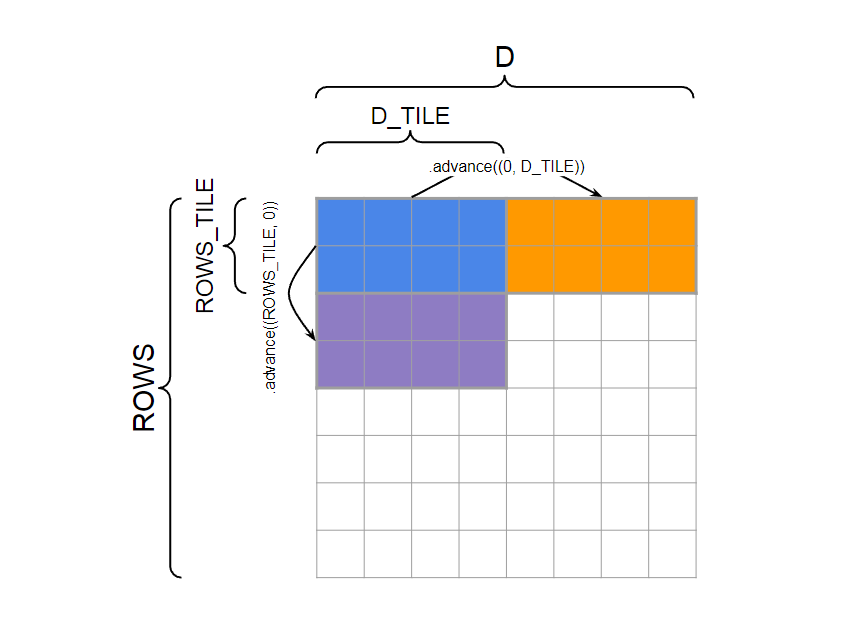

In [ ]:
def weighted_sum(x, weight):
    # Here, assume that x has n-dim shape [..., D], and weight has 1D shape [D]
    return (weight * x).sum(axis=-1)

请参考图上图，了解 tile 的示意图以及如何推进块指针。上述的加权求和函数如下所示

In [ ]:
import triton
import triton.language as tl
from einops import rearrange, einsum
@triton.jit
def weighted_sum_fwd(
    x_ptr, weight_ptr,       # 输入指针
    output_ptr,              # 输出指针
    x_stride_row, x_stride_dim,  # strides 告诉我们如何在张量的每个轴上移动一个元素
    weight_stride_dim,       # 很可能是 1
    output_stride_row,       # 很可能是 1
    ROWS, D,
    ROWS_TILE_SIZE: tl.constexpr, D_TILE_SIZE: tl.constexpr,  # tile 的形状必须在编译时已知
):
    # 每个实例将计算 x 的一块行的加权和
    # `tl.program_id` 给我们一个方法来检查当前线程块的编号
    row_tile_idx = tl.program_id(0)

    # block 指针给我们一个方法，从 ND 内存区域中选择数据
    # 并移动选择位置
    # block 指针必须知道：
    # - 张量第一个元素的指针
    # - 张量的整体形状以处理越界访问
    # - 每个维度的步长，用于使用内存布局属性
    # - 起始块的ND坐标，即“偏移量”
    # - 一次使用/存储的块形状
    # - 内存中主要到次要的维度顺序
    # axes（=np.argsort(strides)）用于优化，特别是在H100上

    x_block_ptr = tl.make_block_ptr(
        x_ptr,
        shape=(ROWS, D,),
        strides=(x_stride_row, x_stride_dim),
        offsets=(row_tile_idx * ROWS_TILE_SIZE, 0),
        block_shape=(ROWS_TILE_SIZE, D_TILE_SIZE),
        order=(1, 0),
    )

    weight_block_ptr = tl.make_block_ptr(
        weight_ptr,
        shape=(D,),
        strides=(weight_stride_dim,),
        offsets=(0,),
        block_shape=(D_TILE_SIZE,),
        order=(0,),
    )

    output_block_ptr = tl.make_block_ptr(
        output_ptr,
        shape=(ROWS,),
        strides=(output_stride_row,),
        offsets=(row_tile_idx * ROWS_TILE_SIZE,),
        block_shape=(ROWS_TILE_SIZE,),
        order=(0,),
    )

    # 初始化一个缓冲区以写入到输出
    output = tl.zeros((ROWS_TILE_SIZE,), dtype=tl.float32)

    for i in range(tl.div(D, D_TILE_SIZE)):
        # 加载当前块指针
        # 由于ROWS_TILE_SIZE可能不能整除ROWS，且D_TILE_SIZE可能不能整除D，
        # 我们需要为两个维度进行边界检查
        row = tl.load(x_block_ptr, boundary_check=(0, 1), padding_option="zero")  # (ROWS_TILE_SIZE, D_TILE_SIZE)
        weight = tl.load(weight_block_ptr, boundary_check=(0,), padding_option="zero")  # (D_TILE_SIZE,)

        # 计算行的加权和。
        output += tl.sum(row * weight[None, :], axis=1)

        # 移动到下一个块。
        # 这些是（行，列）坐标的增量
        x_block_ptr = x_block_ptr.advance((0, D_TILE_SIZE))  # 在最后一个维度移动D_TILE_SIZE
        weight_block_ptr = weight_block_ptr.advance((D_TILE_SIZE,))  # 移动D_TILE_SIZE

        # 将输出写入输出块指针（每行一个标量）
        # 由于ROWS_TILE_SIZE可能不能整除ROWS，我们需要边界检查
        tl.store(output_block_ptr, output, boundary_check=(0,))

# 现在我们将这个内核包装在一个PyTorch自动微分函数中，该函数将与PyTorch（即，接受张量作为输入，输出张量，并在反向传播期间与自动微分引擎一起工作）一起解释
class WeightedSumFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, weight):
        # 在反向传递中缓存x和weight，当我们
        # 只接收到输出张量的梯度时，将使用它们
        # 需要计算x和weight的梯度。
        D, output_dims = x.shape[-1], x.shape[:-1]

        # 将输入张量重塑为2D
        input_shape = x.shape
        x = rearrange(x, "... d -> (...) d")

        ctx.save_for_backward(x, weight)

        assert len(weight.shape) == 1 and weight.shape[0] == D, "维度不匹配"
        assert x.is_cuda and weight.is_cuda, "期望CUDA张量"
        assert x.is_contiguous(), "我们的指针算术将假设x是连续的"

        ctx.D_TILE_SIZE = triton.next_power_of_2(D) // 16  # 大约16次循环遍历嵌入维度
        ctx.ROWS_TILE_SIZE = 16  # 每个线程同时处理16个批次元素
        ctx.input_shape = input_shape

        # 需要初始化一个空的结果张量。注意这些元素不一定是0！
        y = torch.empty(output_dims, device=x.device)

        # 在我们的1D网格中启动我们的内核，有n个实例。
        n_rows = y.numel()
        weighted_sum_fwd[(triton.cdiv(n_rows, ctx.ROWS_TILE_SIZE),)](
            x, weight,
            y,
            x.stride(0), x.stride(1),
            weight.stride(0),
            y.stride(0),
            ROWS=n_rows, D=D,
            ROWS_TILE_SIZE=ctx.ROWS_TILE_SIZE, D_TILE_SIZE=ctx.D_TILE_SIZE,
        )

        return y.view(input_shape[:-1])

实现了一个 **自定义 Triton GPU 算子**，用来完成“对二维矩阵的每一行做加权求和”这一操作，并通过 PyTorch 的 `autograd.Function` 封装，使其可以像普通 PyTorch 函数一样前向/反向传播

------------------------------------------------
一、Triton 内核 `weighted_sum_fwd`
------------------------------------------------
1. 并行划分  
   `@triton.jit` 把函数编译成 CUDA kernel。  
   启动时只给了一维 grid：`weighted_sum_fwd[(grid_dim,)](...)`，  
   所以 `tl.program_id(0)` 就是当前线程块（program instance）在一维网格里的编号，对应“第几个行块”。

2. 块指针（block pointer）  
   `tl.make_block_ptr` 把“张量指针 + 形状/步长/偏移”包装成一个 **可滑动窗口**。  
   `x_ptr` 指向二维矩阵 `(ROWS, D)`  
   `weight_ptr` 指向一维向量 `(D,)`  
   `output_ptr` 指向输出向量 `(ROWS,)`  
   窗口大小由 `ROWS_TILE_SIZE`（=16）和 `D_TILE_SIZE`（编译时常量）决定。  
   `order` 告诉 Triton 哪一维在内存里是主序（row-major 对应 `(1,0)`）。

3. 主循环  
   沿特征维 `D` 以 `D_TILE_SIZE` 为步长滑动窗口：  
   - 加载当前 tile：  
     `row` 形状 `(16, D_TILE_SIZE)`  
     `weight` 形状 `(D_TILE_SIZE,)`  
   - 计算：  
     `row * weight[None, :]` → 广播成 `(16, D_TILE_SIZE)`  
     `tl.sum(..., axis=1)` → 对每行求和，得到 `(16,)`  
     累加到 `output` 寄存器。  
   - 移动窗口：  
     `x_block_ptr.advance((0, D_TILE_SIZE))`  
     `weight_block_ptr.advance((D_TILE_SIZE,))`  
   循环结束后 `output` 里就是 **这 16 行的最终结果**。

4. 写回全局内存  
   `tl.store(output_block_ptr, output, boundary_check=(0,))`  
   如果总行数不能被 16 整除，最末一块会越界，`boundary_check` 自动屏蔽无效元素。

------------------------------------------------
二、PyTorch 封装 `WeightedSumFunc`
------------------------------------------------
1. 参数整理  
   - `x` 可以是任意阶张量，最后一维是特征 `D`；前面所有维度当成“行”。  
   - `weight` 是一维向量，长度必须等于 `D`。  
   用 `einops.rearrange` 把 `x` 压成二维 `(n_rows, D)`，方便内核处理。

2. 静态超参  
   - `ROWS_TILE_SIZE = 16`  
   - `D_TILE_SIZE` 取 `≥D/16` 且为 2 的幂，保证循环次数≈16 次，兼顾寄存器占用与并行度。

3. 输出张量  
   `y = torch.empty(output_dims)` 形状与 `x[..., 0]` 相同。

4. 启动 kernel  
   grid 大小 = `ceil(n_rows / 16)`，每个线程块负责 16 行。  
   把张量底层指针、步长、行列数等全部传进 Triton 内核。

5. 返回  
   把二维结果再 `view` 回原来的 batch 形状，前端用户感知不到内存重排。

------------------------------------------------
三、整体流程
------------------------------------------------
```python
out = WeightedSumFunc.apply(x, weight)
```

等价于  
```python
out = (x * weight).sum(dim=-1)
```

但 **完全跑在 GPU 上，手工调度共享内存/寄存器，比 PyTorch 原生 reduce 更快**，尤其当 `D` 很大、batch 很多时。后续只要再补一个 `backward` 函数，就可以像普通 `nn.Module` 一样训练。

### **FlashAttention 中「分块（blocking）」与「数值稳定 softmax」为什么能带来加速**


### 一、加速原理

FlashAttention 的加速**不是因为算得更少 FLOPs**，而是因为：

> **极大减少了显存读写（memory I/O），并将计算变成“流式（streaming）”**

核心公式仍然是论文中的公式：

$$
\text{softmax}(QK^T)V
$$

但**计算路径完全改变**。

####  标准 Attention 的真实成本

以 sequence length = (N)，head dim = (d)：

| 操作      | FLOPs      | 显存占用          |
| ------- | ---------- | ------------- |
| QKᵀ     | (O(N^2 d)) | **存 N×N**     |
| softmax | (O(N^2))   | **读 + 写 N×N** |
| AV      | (O(N^2 d)) | 读 N×N         |

**关键瓶颈不是算力，而是显存带宽**

在 GPU 上：N×N的attention matrix **必须写入 HBM**，* 然后再 **从 HBM 读回** 做 softmax，大模型场景下 **显存访问 >> 计算时间**。

#### GPU 性能的现实约束

GPU 有三种“速度等级”存储：

| 存储            | 速度 | 容量 |
| ------------- | -- | -- |
| Register      | 极快 | 极小 |
| Shared Memory | 快  | 小  |
| HBM (显存)      | 慢  | 很大 |

标准 Attention 的问题是：

> **N×N attention matrix 太大，只能进 HBM**

#### 分块（Blocking）为什么能加速

**分块的本质就是让数据“活在片上”**

FlashAttention 将 Attention 重写为：

```text
for each Q_block:
    for each K/V_block:
        计算局部 QK^T
        立刻参与 softmax
        立刻乘 V
```

核心变化是不再生成完整的 QKᵀ，不再写入 N×N matrix，局部结果 **只存在寄存器 / shared memory**。从**全文总结变成了走一步看一步**。

#### 分块前 vs 分块后（显存行为对比）

**标准 Attention**

```text
HBM:
  写 QK^T (N×N)
  读 QK^T
  写 softmax(QK^T)
  读 softmax(QK^T)
```

**HBM I/O = O(N²)**

---

**FlashAttention（分块）**

```text
HBM:
  读 Q_block
  读 K_block, V_block
  写 O_block
```

**HBM I/O = O(N·d)**

**这是数量级的下降**

---

### 为什么“只对 K/V 分块也有效”

分块有两种实现：

* Q 不分块
* Q 分块（论文 / CUDA 版）

两者都满足：

> **K/V 被流式读取，attention matrix 不落地**

Q 分块是为了，提高 occupancy，并且控制寄存器使用，适配 CUDA block 结构。

---

#### 二、在线 softmax 的加速原理”

**标准 softmax 的结构问题**

标准 softmax：

```python
S = QK^T
P = exp(S) / sum(exp(S))
```

问题在于softmax **必须看完整一行**，无法流式，依赖全量 S。

**这强制我们先存下整个 QKᵀ**


**running max / running sum 的革命性意义**

FlashAttention 使用：

$$
\begin{aligned}
m_i &= \max_j S_{ij} \
l_i &= \sum_j e^{S_{ij} - m_i}
\end{aligned}
$$

并改写为 **可递推形式**：

$$
m_i^{(t)} = \max(m_i^{(t-1)}, \max S_{ij}^{(t)})
$$

$$
l_i^{(t)} =
l_i^{(t-1)} e^{m_i^{(t-1)} - m_i^{(t)}} +
\sum e^{S_{ij}^{(t)} - m_i^{(t)}}
$$


这一步“决定了 FlashAttention 能不能存在”，它带来了三件**决定性好处**，将softmax 变成 **在线算法**。

再这个算法中我们不需要完整 S，每来一个 block 就能更新，天然适配 streaming。

**softmax 与 AV 可以融合**

标准 Attention：

```text
QK^T → softmax → @V
```

FlashAttention：

```text
(QK^T → exp → sum → @V)  全部在 block 内完成
```

**算子融合（kernel fusion）成为可能**


**backward 也不需要 attention matrix**

由于 forward 保存了：

* `L = logsumexp`
* `O = softmax @ V`

backward 可写成：

$$
dS_{ij} = P_{ij} (dP_{ij} - D_i)
$$

**反向同样 O(N) 显存**

> FlashAttention 的加速不是减少计算，而是通过 **分块 + 在线 softmax**，
> **避免了 N×N attention matrix 的显存读写**，
> 将 attention 计算变成一个 **完全流式、可融合的过程**，
> 从而把瓶颈从显存带宽转回到算力。




# 作业七：使用pytorch实现flash attention

In [13]:
import torch

class FlashAttentionAutograd(torch.autograd.Function):
    """
    FlashAttention（forward + backward）

    输入：
        Q: (B, Nq, d)
        K: (B, Nk, d)
        V: (B, Nk, d)

    输出：
        O: (B, Nq, d)
    """

    @staticmethod
    def forward(ctx, Q, K, V):
        B, Nq, d = Q.shape
        Nk = K.shape[1]

        # -----------------------------
        # block size
        # -----------------------------
        Bq = 64  # Query block 的尺寸
        Bk = 64  # Key / Value block 的尺寸

        # 我们将KV矩阵分成一个个小矩阵

        Tq = Nq // Bq  # Q block 数
        Tk = Nk // Bk  # K/V block 数

        scale = d ** -0.5

        # -----------------------------
        # 输出与中间量
        # -----------------------------
        O = torch.zeros_like(Q)              # Attention 输出
        L = torch.zeros(B, Nq, device=Q.device)  # log-sum-exp（给 backward 用）

        # =========================================================
        # 对 batch 维度显式循环
        # =========================================================
        for b in range(B):
            Q_b = Q[b]  # (Nq, d)
            K_b = K[b]  # (Nk, d)
            V_b = V[b]  # (Nk, d)

            # =====================================================
            # 外层循环：Query block
            # =====================================================
            for i in range(Tq):
                q_i = Q_b[i * Bq:(i + 1) * Bq]  # (Bq, d)

                # -----------------------------
                # FlashAttention 核心状态
                # -----------------------------
                m = torch.full((Bq, 1), -float("inf"), device=Q.device)  # running max
                l = torch.zeros((Bq, 1), device=Q.device)               # running sum
                O_acc = torch.zeros((Bq, d), device=Q.device)           # 输出累积（未归一化）

                # =================================================
                # 内层循环：Key / Value block
                # =================================================
                for j in range(Tk):
                    k_j = K_b[j * Bk:(j + 1) * Bk]  # (Bk, d)
                    v_j = V_b[j * Bk:(j + 1) * Bk]  # (Bk, d)

                    # --------------------------------------------
                    # 计算局部 attention score
                    # S_ij = Q_i @ K_j^T / sqrt(d)
                    # --------------------------------------------
                    S = q_i @ k_j.T * scale  # (Bq, Bk)

                    # 当前 block 内，每一行的最大值
                    row_max = S.max(dim=1, keepdim=True).values  # (Bq, 1)

                    # 更新 running max
                    m_new = torch.maximum(m, row_max)

                    # --------------------------------------------
                    # 数值稳定 softmax（FlashAttention 关键）
                    # --------------------------------------------
                    # 旧 block 贡献修正
                    exp_old = torch.exp(m - m_new) * l

                    # 当前 block 的 exp
                    P = torch.exp(S - m_new)

                    # 更新分母
                    l = exp_old + P.sum(dim=1, keepdim=True)

                    # 更新未归一化输出
                    O_acc = (
                        torch.exp(m - m_new) * O_acc +
                        P @ v_j
                    )

                    # 写回 running max
                    m = m_new

                # =================================================
                # block 内 softmax 归一化
                # =================================================
                O_i = O_acc / l  # (Bq, d)

                # log-sum-exp：L = m + log(l)
                L_i = m.squeeze(1) + torch.log(l.squeeze(1))

                # 写回全局输出
                O[b, i * Bq:(i + 1) * Bq] = O_i
                L[b, i * Bq:(i + 1) * Bq] = L_i

        # 保存 backward 所需变量
        ctx.save_for_backward(Q, K, V, O, L)
        ctx.scale = scale
        ctx.Bq = Bq
        ctx.Bk = Bk

        return O
    
    @staticmethod
    def backward(ctx, dO):
        Q, K, V, O, L = ctx.saved_tensors
        scale = ctx.scale
        Bq = ctx.Bq
        Bk = ctx.Bk

        B, Nq, d = Q.shape
        Nk = K.shape[1]

        Tq = Nq // Bq
        Tk = Nk // Bk

        # --------------------------------------------
        # FlashAttention backward 中的重要中间量
        # D_i = sum_j O_ij * dO_ij
        # --------------------------------------------
        D = torch.sum(O * dO, dim=-1)  # (B, Nq)

        dQ = torch.zeros_like(Q)
        dK = torch.zeros_like(K)
        dV = torch.zeros_like(V)

        for b in range(B):
            for i in range(Tq):
                q_i = Q[b, i * Bq:(i + 1) * Bq]
                dO_i = dO[b, i * Bq:(i + 1) * Bq]
                L_i = L[b, i * Bq:(i + 1) * Bq]
                D_i = D[b, i * Bq:(i + 1) * Bq]

                for j in range(Tk):
                    k_j = K[b, j * Bk:(j + 1) * Bk]
                    v_j = V[b, j * Bk:(j + 1) * Bk]

                    # --------------------------------------------
                    # 重算局部 attention 概率 P_ij
                    # P_ij = exp(S_ij - L_i)
                    # --------------------------------------------
                    S = q_i @ k_j.T * scale
                    P = torch.exp(S - L_i.unsqueeze(1))

                    # -------- dV --------
                    dV[b, j * Bk:(j + 1) * Bk] += P.T @ dO_i

                    # -------- dS --------
                    dP = dO_i @ v_j.T
                    dS = P * (dP - D_i.unsqueeze(1))

                    # -------- dQ --------
                    dQ[b, i * Bq:(i + 1) * Bq] += dS @ k_j * scale

                    # -------- dK --------
                    dK[b, j * Bk:(j + 1) * Bk] += dS.T @ q_i * scale

        return dQ, dK, dV


In [9]:

import time
from typing import Callable
from torch.profiler import ProfilerActivity
import os

def mean(values: list[float]) -> float:
    if not values:
        raise ValueError("mean() requires at least one value")
    return sum(values) / len(values)

def benchmark(description: str, run: Callable, num_warmups: int = 1, num_trials: int = 3):
    """Benchmark `func` by running it `num_trials`, and return all the times."""
    # 热身：第一次运行可能较慢,因为要编译和缓存
    # 我们将多次要运行内核，因为重要的是稳态的运行时间。
    for _ in range(num_warmups):
        run()
    if torch.cuda.is_available():
        torch.cuda.synchronize()  # 等待 CUDA 线程完成（非常重要！）
    print('现在真正计时!')
    times: list[float] = [] # @inspect times, @inspect description

    for trial in range(num_trials):  # 多次重复
        start_time = time.time()
        run()  # 实际执行计算
        if torch.cuda.is_available():
            torch.cuda.synchronize()  # 等待 CUDA 线程 完成同步
        end_time = time.time()
        times.append((end_time - start_time) * 1000) # @inspect times
    mean_time = mean(times) # 多次测量取平均

    print(f'单次耗时：{mean_time  }ms')
    return mean_time 

def profile(description: str, run: Callable, num_warmups: int = 1, with_stack: bool = False):
    # 预热
    for _ in range(num_warmups):
        run()
    if torch.cuda.is_available():
        print("正在使用cuda")
        torch.cuda.synchronize()  # 等待CUDA线程结束
    else:
        print('正在使用cpu')
    # 使用性能分析器运行代码
    
    with torch.profiler.profile(
            activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
            # 输出堆栈跟踪以进行可视化
            with_stack=with_stack,
            #  需要导出堆栈跟踪以进行可视化
            experimental_config=torch._C._profiler._ExperimentalConfig(verbose=True)) as prof:
        run()
        if torch.cuda.is_available():
            torch.cuda.synchronize()  # 等待CUDA线程结束
    # 打印表格
    table = prof.key_averages().table(
        sort_by="self_cuda_time_total",
        max_name_column_width=80,
        row_limit=10,
        top_level_events_only=False) 
    #text(f"## {description}")
    #text(table, verbatim=True)
    # Write stack trace visualization
    if with_stack:
        os.makedirs("var", exist_ok=True)
        text_path = f"var/stacks_{description}.txt"
        svg_path = f"var/stacks_{description}.svg"
        prof.export_stacks(text_path, "self_cuda_time_total")
    return table



In [5]:
def test_flash_attention(B=1, N=1024, d=64, device="cuda"):
    torch.manual_seed(0)

    Q = torch.randn(B, N, d, device=device, requires_grad=True)
    K = torch.randn(B, N, d, device=device, requires_grad=True)
    V = torch.randn(B, N, d, device=device, requires_grad=True)

    def run():
        O = FlashAttentionAutograd.apply(Q, K, V)
        #loss = O.sum()
        #loss.backward()

    t = benchmark(description= 'test_flash_attention',run = run)
    t1 = profile(description ='test_flash_attention' , run = run, num_warmups = 3, with_stack = True)
    
    print(f"[FlashAttention] B={B}, N={N}, d={d}, time={t*1000:.3f} ms")
    print(t1)



def naive_attention(Q, K, V):
    d = Q.size(-1)
    scores = Q @ K.transpose(-2, -1) / (d ** 0.5)
    P = torch.softmax(scores, dim=-1)
    return P @ V
def test_naive_attention(B=1, N=1024, d=64, device="cuda"):
    torch.manual_seed(0)

    Q = torch.randn(B, N, d, device=device, requires_grad=True)
    K = torch.randn(B, N, d, device=device, requires_grad=True)
    V = torch.randn(B, N, d, device=device, requires_grad=True)

    def run():
        O = naive_attention(Q, K, V)
        #loss = O.sum()
        #loss.backward()

    t = benchmark(description= 'test_attention',run = run)
    t1 = profile(description ='test_attention' , run = run, num_warmups = 3, with_stack = True)
    print(f"[NaiveAttention]  B={B}, N={N}, d={d}, time={t*1000:.3f} ms")
    print(t1)


device = "cuda"

for N in [1024]:
    test_flash_attention(B=1, N=N, d=64, device=device)
    test_naive_attention(B=1, N=N, d=64, device=device)
    print("-" * 50)


现在真正计时!
单次耗时：50.60640970865885ms
正在使用cuda
[FlashAttention] B=1, N=1024, d=64, time=50606.410 ms
--------------------------------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
--------------------------------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                                        aten::mm         4.09%       7.780ms        13.67%      26.013ms      50.806us      63.793ms        58.75%      65.305ms     127.549us           512  
           

# 2. Triton 内核实现flash attention

Triton 是一个用 Python 写 GPU kernel 的 DSL，本质上是“显式控制数据分块与内存层级的编程模型”，它不是NumPy，也不是高层 PyTorch API，它是一个 CUDA kernel 的“可读版本”。

In [4]:
# from sympy import Q
import torch
import triton
import triton.language as tl

@triton.jit
def flash_attention_fwd_kernel(
    # -------- 全局内存指针 --------
    Q_ptr, K_ptr, V_ptr,           # 输入 Q, K, V
    O_ptr, L_ptr,                  # 输出 O, logsumexp L

    # -------- stride 信息（用于 block ptr）--------
    stride_qb, stride_qn, stride_qd,
    stride_kb, stride_kn, stride_kd,
    stride_vb, stride_vn, stride_vd,
    stride_ob, stride_on, stride_od,
    stride_lb, stride_ln,

    # -------- 序列长度 --------
    Nq, Nk,

    # -------- scale --------
    scale,

    # -------- 编译期常量 --------
    D: tl.constexpr,
    Q_BLOCK: tl.constexpr,
    K_BLOCK: tl.constexpr,
    is_causal: tl.constexpr,
):
    """
    每个 Triton program 负责：
        - 一个 batch
        - 一个 Query block（Q_BLOCK 行）
    """

    # ------------------------------------------------
    # Triton 并行索引
    # ------------------------------------------------
    q_block_id = tl.program_id(0)     # 第几个 Q block
    batch_id   = tl.program_id(1)     # 第几个 batch

    # =================================================
    # 构造 block pointer（这是 Triton 的关键）
    # =================================================
    Q_block_ptr = tl.make_block_ptr(
        base=Q_ptr + batch_id * stride_qb,
        shape=(Nq, D),
        strides=(stride_qn, stride_qd),
        offsets=(q_block_id * Q_BLOCK, 0),
        block_shape=(Q_BLOCK, D),
        order=(1, 0),
    )

    #  K / V 从第 0 行开始，后面在 loop 中 advance
    K_block_ptr = tl.make_block_ptr(
        base=K_ptr + batch_id * stride_kb,
        shape=(Nk, D),
        strides=(stride_kn, stride_kd),
        offsets=(0, 0),
        block_shape=(K_BLOCK, D),
        order=(1, 0),
    )

    V_block_ptr = tl.make_block_ptr(
        base=V_ptr + batch_id * stride_vb,
        shape=(Nk, D),
        strides=(stride_vn, stride_vd),
        offsets=(0, 0),
        block_shape=(K_BLOCK, D),
        order=(1, 0),
    )

    O_block_ptr = tl.make_block_ptr(
        base=O_ptr + batch_id * stride_ob,
        shape=(Nq, D),
        strides=(stride_on, stride_od),
        offsets=(q_block_id * Q_BLOCK, 0),
        block_shape=(Q_BLOCK, D),
        order=(1, 0),
    )

    L_block_ptr = tl.make_block_ptr(
        base=L_ptr + batch_id * stride_lb,
        shape=(Nq, 1),
        strides=(stride_ln, 1),
        offsets=(q_block_id * Q_BLOCK, 0),
        block_shape=(Q_BLOCK, 1),
        order=(1, 0),
    )

    # =================================================
    # 加载 Query block
    # =================================================
    Q_i = tl.load(Q_block_ptr)  # (Q_BLOCK, D)

    # =================================================
    # FlashAttention 核心状态（每个 Q block 独立）
    # =================================================
    O_acc = tl.zeros((Q_BLOCK, D), dtype=tl.float32)       # 未归一化输出累积
    L_acc = tl.zeros((Q_BLOCK, 1), dtype=tl.float32)      # softmax 分母
    M_acc = tl.full((Q_BLOCK, 1), -float("inf"), tl.float32)  # running max

    # =================================================
    # 内层循环：遍历所有 K/V block
    # =================================================
    for k_block_id in range(tl.cdiv(Nk, K_BLOCK)):
        K_j = tl.load(K_block_ptr)   # (K_BLOCK, D)
        V_j = tl.load(V_block_ptr)   # (K_BLOCK, D)

        # ---------------------------------------------
        # S_ij = Q_i @ K_j^T / sqrt(d)
        # ---------------------------------------------
        S_ij = tl.dot(Q_i, K_j.T) * scale  # (Q_BLOCK, K_BLOCK)

        # ---------------------------------------------
        # Causal mask（编译期 if）
        # ---------------------------------------------
        if is_causal:
            q_idx = q_block_id * Q_BLOCK + tl.arange(0, Q_BLOCK)[:, None]
            k_idx = k_block_id * K_BLOCK + tl.arange(0, K_BLOCK)[None, :]
            causal_mask = q_idx >= k_idx
            S_ij = tl.where(causal_mask, S_ij, -1e6)

        # ---------------------------------------------
        # 数值稳定 softmax（FlashAttention 核心）
        # ---------------------------------------------
        M_block = tl.max(S_ij, axis=1, keep_dims=True)
        M_new = tl.maximum(M_acc, M_block)

        P_ij = tl.exp(S_ij - M_block)

        L_new = (
            tl.exp(M_acc - M_new) * L_acc +
            tl.exp(M_block - M_new) * tl.sum(P_ij, axis=1, keep_dims=True)
        )

        # 类型对齐（Triton 细节）
        P_cast = P_ij.to(V_block_ptr.type.element_ty)

        O_new = (
            tl.exp(M_acc - M_new) * O_acc +
            tl.exp(M_block - M_new) * tl.dot(P_cast, V_j)
        )

        # ---------------------------------------------
        # 更新 running 状态
        # ---------------------------------------------
        M_acc = M_new
        L_acc = L_new
        O_acc = O_new

        # ---------------------------------------------
        # 移动 K/V block 指针
        # ---------------------------------------------
        K_block_ptr = K_block_ptr.advance((K_BLOCK, 0))
        V_block_ptr = V_block_ptr.advance((K_BLOCK, 0))

    # =================================================
    # softmax 归一化
    # =================================================
    O_i = O_acc / L_acc
    L_i = M_acc + tl.log(L_acc)

    tl.store(O_block_ptr, O_i)
    tl.store(L_block_ptr, L_i)

@triton.jit
def flash_bwd_kernel(
    Q_ptr, K_ptr, V_ptr, O_ptr, L_ptr, dO_ptr, D_ptr,
    dQ_ptr, dK_ptr, dV_ptr,
    stride_qb, stride_qq, stride_qd,
    stride_kb, stride_kk, stride_kd,
    stride_vb, stride_vk, stride_vd,
    stride_ob, stride_oq, stride_od,
    stride_lb, stride_lq,
    stride_dob, stride_doq, stride_dod,
    stride_db, stride_dq_d,
    N_QUERIES, N_KEYS,
    scale,
    D: tl.constexpr,
    Q_TILE_SIZE: tl.constexpr,
    K_TILE_SIZE: tl.constexpr,
    is_causal: tl.constexpr,
):
    # program ids
    k_tile_id = tl.program_id(0)
    batch_id = tl.program_id(1)

    # -------------------------
    # block pointers (Q-side)
    # -------------------------
    Q_block_ptr = tl.make_block_ptr(
        base=Q_ptr + batch_id * stride_qb,
        shape=(N_QUERIES, D),
        strides=(stride_qq, stride_qd),
        offsets=(0, 0),
        block_shape=(Q_TILE_SIZE, D),
        order=(1, 0),
    )
    O_block_ptr = tl.make_block_ptr(
        O_ptr + batch_id * stride_ob,
        shape=(N_QUERIES, D),
        strides=(stride_oq, stride_od),
        offsets=(0, 0),
        block_shape=(Q_TILE_SIZE, D),
        order=(1, 0),
    )
    dO_block_ptr = tl.make_block_ptr(
        dO_ptr + batch_id * stride_dob,
        shape=(N_QUERIES, D),
        strides=(stride_doq, stride_dod),
        offsets=(0, 0),
        block_shape=(Q_TILE_SIZE, D),
        order=(1, 0),
    )
    L_block_ptr = tl.make_block_ptr(
        L_ptr + batch_id * stride_lb,
        shape=(N_QUERIES, 1),
        strides=(stride_lq, 1),
        offsets=(0, 0),
        block_shape=(Q_TILE_SIZE, 1),
        order=(1, 0),
    )
    D_block_ptr = tl.make_block_ptr(
        D_ptr + batch_id * stride_db,
        shape=(N_QUERIES, 1),
        strides=(stride_dq_d, 1),
        offsets=(0, 0),
        block_shape=(Q_TILE_SIZE, 1),
        order=(1, 0),
    )

    # -------------------------
    # block pointers (K/V-side)
    # -------------------------
    K_block_ptr = tl.make_block_ptr(
        K_ptr + batch_id * stride_kb,
        shape=(N_KEYS, D),
        strides=(stride_kk, stride_kd),
        offsets=(k_tile_id * K_TILE_SIZE, 0),
        block_shape=(K_TILE_SIZE, D),
        order=(1, 0),
    )
    V_block_ptr = tl.make_block_ptr(
        V_ptr + batch_id * stride_vb,
        shape=(N_KEYS, D),
        strides=(stride_vk, stride_vd),
        offsets=(k_tile_id * K_TILE_SIZE, 0),
        block_shape=(K_TILE_SIZE, D),
        order=(1, 0),
    )
    dK_block_ptr = tl.make_block_ptr(
        dK_ptr + batch_id * stride_kb,
        shape=(N_KEYS, D),
        strides=(stride_kk, stride_kd),
        offsets=(k_tile_id * K_TILE_SIZE, 0),
        block_shape=(K_TILE_SIZE, D),
        order=(1, 0),
    )
    dV_block_ptr = tl.make_block_ptr(
        dV_ptr + batch_id * stride_vb,
        shape=(N_KEYS, D),
        strides=(stride_vk, stride_vd),
        offsets=(k_tile_id * K_TILE_SIZE, 0),
        block_shape=(K_TILE_SIZE, D),
        order=(1, 0),
    )

    # -------------------------
    # load K/V tile
    # -------------------------
    K_j = tl.load(K_block_ptr)  # (K_TILE_SIZE, D)
    V_j = tl.load(V_block_ptr)

    dK_j = tl.zeros((K_TILE_SIZE, D), dtype=tl.float32)
    dV_j = tl.zeros((K_TILE_SIZE, D), dtype=tl.float32)

    # -------------------------
    # loop over Q tiles
    # -------------------------
    for q_tile_id in range(tl.cdiv(N_QUERIES, Q_TILE_SIZE)):
        Q_i = tl.load(Q_block_ptr)
        O_i = tl.load(O_block_ptr)
        dO_i = tl.load(dO_block_ptr)
        L_i = tl.load(L_block_ptr)
        D_i = tl.load(D_block_ptr)

        # S = QK^T
        S_ij = tl.dot(Q_i, K_j.T) * scale

        if is_causal:
            q_idx = q_tile_id * Q_TILE_SIZE + tl.arange(0, Q_TILE_SIZE)[:, None]
            k_idx = k_tile_id * K_TILE_SIZE + tl.arange(0, K_TILE_SIZE)[None, :]
            S_ij = tl.where(q_idx >= k_idx, S_ij, -1e6)

        # P = softmax
        P_ij = tl.exp(S_ij - L_i)

        # dV
        dV_j += tl.dot(P_ij.to(V_j.dtype).T, dO_i)

        # dP
        dP_ij = tl.dot(dO_i, V_j.T)

        # dS
        dS_ij = P_ij * (dP_ij - D_i)
        dS_ij = dS_ij * scale

        # dQ (atomic add)
        dQ_i = tl.dot(dS_ij, K_j)

        q_idx = q_tile_id * Q_TILE_SIZE + tl.arange(0, Q_TILE_SIZE)[:, None]
        d_idx = tl.arange(0, D)[None, :]
        mask = (q_idx < N_QUERIES) & (d_idx < D)
        dq_ptrs = dQ_ptr + batch_id * stride_qb + q_idx * stride_qq + d_idx * stride_qd
        tl.atomic_add(dq_ptrs, dQ_i.to(dQ_ptr.dtype.element_ty), mask=mask)

        # dK
        dK_j += tl.dot(dS_ij.T, Q_i)

        # advance Q-side blocks
        Q_block_ptr = Q_block_ptr.advance((Q_TILE_SIZE, 0))
        O_block_ptr = O_block_ptr.advance((Q_TILE_SIZE, 0))
        dO_block_ptr = dO_block_ptr.advance((Q_TILE_SIZE, 0))
        L_block_ptr = L_block_ptr.advance((Q_TILE_SIZE, 0))
        D_block_ptr = D_block_ptr.advance((Q_TILE_SIZE, 0))

    # -------------------------
    # store dK / dV
    # -------------------------
    tl.store(dK_block_ptr, dK_j.to(dK_ptr.dtype.element_ty))
    tl.store(dV_block_ptr, dV_j.to(dV_ptr.dtype.element_ty))



class FlashAttentionTriton(torch.autograd.Function):
    @staticmethod
    def forward(ctx, Q, K, V, is_causal=False):
        """
        Q, K, V: (B, N, D)
        """

        B, Nq, D = Q.shape
        Nk = K.shape[1]

        Q_BLOCK = 16
        K_BLOCK = 16

        scale = D ** -0.5

        O = torch.empty_like(Q)
        L = torch.empty(B, Nq, device=Q.device)

        grid = (Nq // Q_BLOCK, B)

        flash_attention_fwd_kernel[grid](
            Q, K, V, O, L,
            Q.stride(0), Q.stride(1), Q.stride(2),
            K.stride(0), K.stride(1), K.stride(2),
            V.stride(0), V.stride(1), V.stride(2),
            O.stride(0), O.stride(1), O.stride(2),
            L.stride(0), L.stride(1),
            Nq, Nk,
            scale,
            D=D,
            Q_BLOCK=Q_BLOCK,
            K_BLOCK=K_BLOCK,
            is_causal=is_causal,
        )

        ctx.save_for_backward(Q, K, V, O, L)
        ctx.is_causal = is_causal
        return O
    @staticmethod
    def backward(ctx, do):
        q, k, v, o, l = ctx.saved_tensors
        is_causal = ctx.is_causal
    
        B, Nq, D = q.shape
        Nk = k.shape[1]
    
        Bq = 16
        Bk = 16
        scale = D ** -0.5
    
        dq = torch.zeros_like(q)
        dk = torch.zeros_like(k)
        dv = torch.zeros_like(v)
    
        # D_i = sum_j dO_ij * O_ij
        D_sum = torch.sum(o * do, dim=-1, keepdim=True)
    
        grid = (triton.cdiv(Nk, Bk), B)
    
        flash_bwd_kernel[grid](
            q, k, v, o, l, do, D_sum,
            dq, dk, dv,
            q.stride(0), q.stride(1), q.stride(2),
            k.stride(0), k.stride(1), k.stride(2),
            v.stride(0), v.stride(1), v.stride(2),
            o.stride(0), o.stride(1), o.stride(2),
            l.stride(0), l.stride(1),
            do.stride(0), do.stride(1), do.stride(2),
            D_sum.stride(0), D_sum.stride(1),
            Nq, Nk,
            scale,
            D=D,
            Q_TILE_SIZE=Bq,
            K_TILE_SIZE=Bk,
            is_causal=is_causal,
        )
    
        return dq, dk, dv, None
    


In [5]:
import torch
import time

def benchmark_attention(device="cuda"):
    torch.manual_seed(0)

    batch_size = 8
    d_models = [16, 32, 64, 128]
    seqlens = [256, 1024, 4096, 8192, 16384]

    results = []

    for d_model in d_models:
        for seqlen in seqlens:
            try:
                # 构造输入（无多头）
               
                Q = torch.randn(batch_size, seqlen, d_model, device=device, requires_grad=True).to(device)
                K = torch.randn(batch_size, seqlen, d_model, device=device, requires_grad=True).to(device)
                V = torch.randn(batch_size, seqlen, d_model, device=device, requires_grad=True).to(device)


                # warm-up
                with torch.no_grad():
                    for _ in range(10):
                        out = FlashAttentionTriton.apply(Q, K, V)
                        #loss = out.sum()
                        #loss.backward()
                    torch.cuda.synchronize()

                # forward timing
                start = time.time()
                for _ in range(100):
                    out = FlashAttentionTriton.apply(Q, K, V)
                torch.cuda.synchronize()
                forward_time = (time.time() - start) / 100

                # memory before backward
                mem_before_backward = torch.cuda.memory_allocated()

                
                #---------------------
                # backward timing
                start = time.time()
                for _ in range(100):
                    out = FlashAttentionTriton.apply(Q, K, V)
                    loss = out.sum()
                    loss.backward()
                torch.cuda.synchronize()
                backward_time = (time.time() - start) / 100
                #-------------------------
                results.append({
                    "d_model": d_model,
                    "seqlen": seqlen,
                    "forward_time_ms": forward_time * 1000,
                    #"backward_time_ms": backward_time * 1000,
                    "mem_MB": mem_before_backward / 1024**2,
                })

                print(f"OK: d={d_model}, T={seqlen}")

            except RuntimeError as e:
                if "out of memory" in str(e):
                    results.append({
                        "d_model": d_model,
                        "seqlen": seqlen,
                        "OOM": True
                    })
                    print(f"OOM: d={d_model}, T={seqlen}")
                    torch.cuda.empty_cache()
                else:
                    raise e

    return results


In [6]:

benchmark_attention()


OK: d=16, T=256
OK: d=16, T=1024
OK: d=16, T=4096
OK: d=16, T=8192
OK: d=16, T=16384
OK: d=32, T=256
OK: d=32, T=1024
OK: d=32, T=4096
OK: d=32, T=8192
OK: d=32, T=16384
OK: d=64, T=256
OK: d=64, T=1024
OK: d=64, T=4096
OK: d=64, T=8192
OK: d=64, T=16384
OK: d=128, T=256
OK: d=128, T=1024
OK: d=128, T=4096
OK: d=128, T=8192
OK: d=128, T=16384


[{'d_model': 16,
  'seqlen': 256,
  'forward_time_ms': 0.18090486526489258,
  'mem_MB': 7.5244140625},
 {'d_model': 16,
  'seqlen': 1024,
  'forward_time_ms': 0.220947265625,
  'mem_MB': 9.79833984375},
 {'d_model': 16,
  'seqlen': 4096,
  'forward_time_ms': 3.0855512619018555,
  'mem_MB': 18.14208984375},
 {'d_model': 16,
  'seqlen': 8192,
  'forward_time_ms': 12.349913120269775,
  'mem_MB': 35.26708984375},
 {'d_model': 16,
  'seqlen': 16384,
  'forward_time_ms': 78.64851951599121,
  'mem_MB': 63.51708984375},
 {'d_model': 32,
  'seqlen': 256,
  'forward_time_ms': 0.0536036491394043,
  'mem_MB': 56.02490234375},
 {'d_model': 32,
  'seqlen': 1024,
  'forward_time_ms': 0.2613353729248047,
  'mem_MB': 12.54833984375},
 {'d_model': 32,
  'seqlen': 4096,
  'forward_time_ms': 4.055523872375488,
  'mem_MB': 29.14208984375},
 {'d_model': 32,
  'seqlen': 8192,
  'forward_time_ms': 15.804851055145265,
  'mem_MB': 63.26708984375},
 {'d_model': 32,
  'seqlen': 16384,
  'forward_time_ms': 63.9749

如果报错out of resource: shared memory, Required: 115200, Hardware limit: 101376. Reducing block sizes or num_stages may help.

适当将Q_BLOCK = 16 和 K_BLOCK = 16还有Bq = 16 ，Bk = 16调低，如果你的GPU非常给力，也可以适当调高，我用的是4060 -8G

In [7]:
def test_flash_AttentionTriton(B=4, N=4096, d=64, device="cuda"):
    torch.manual_seed(0)

    Q = torch.randn(B, N, d, device=device, requires_grad=True)
    K = torch.randn(B, N, d, device=device, requires_grad=True)
    V = torch.randn(B, N, d, device=device, requires_grad=True)

    def run():
        O = FlashAttentionTriton.apply(Q, K, V)
        loss = O.sum()
        loss.backward()

    t = benchmark(description= 'FlashAttentionTriton',run = run)
    t1 = profile(description ='FlashAttentionTriton' , run = run, num_warmups = 3, with_stack = True)
    
    print(f"[FlashAttentionTriton] B={B}, N={N}, d={d}, time={t*1000:.3f} ms")
    print(t1)


In [10]:
test_flash_AttentionTriton()

现在真正计时!
单次耗时：50.40081342061361ms
正在使用cuda
[FlashAttentionTriton] B=4, N=4096, d=64, time=50400.813 ms
--------------------------------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
--------------------------------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                    FlashAttentionTritonBackward         0.15%     381.197us         0.22%     567.242us     567.242us     213.809ms        85.45%     214.310ms     214.310ms             1  
     

In [11]:
def test_flash_attention(B=1, N=1024, d=64, device="cuda"):
    torch.manual_seed(0)

    Q = torch.randn(B, N, d, device=device, requires_grad=True)
    K = torch.randn(B, N, d, device=device, requires_grad=True)
    V = torch.randn(B, N, d, device=device, requires_grad=True)

    def run():
        O = FlashAttentionAutograd.apply(Q, K, V)
        #loss = O.sum()
        #loss.backward()

    t = benchmark(description= 'test_flash_attention',run = run)
    t1 = profile(description ='test_flash_attention' , run = run, num_warmups = 3, with_stack = True)
    
    print(f"[FlashAttention] B={B}, N={N}, d={d}, time={t*1000:.3f} ms")
    print(t1)


# Triton 一般语法与编程模型说明

Triton 是一种面向深度学习算子的 DSL（Domain-Specific Language），其设计目标并不是替代 PyTorch，而是 **在不直接编写 CUDA 的前提下，精确控制 GPU 上的并行计算与内存访问**。

理解 Triton，需要从它的编程模型开始，而不是从 API 细节入手。

---

## 一、Triton 的核心抽象：program

在 Triton 中，**program 是最小的并行执行单元**。

```python
pid = tl.program_id(axis)
```

这一概念对应于 CUDA 中的：

| Triton  | CUDA                    |
| ------- | ----------------------- |
| program | thread block            |
| grid    | grid                    |
| axis    | blockIdx.x / blockIdx.y |

关键区别在于：

* Triton 的 program **天然是 SIMD / 向量化的**
* 一个 program 内部，操作的是一个 **tile（块）**，而不是单个标量

因此，Triton 的思维方式是：

> **“一个 program 负责一块数据”**

而不是：

> “一个 thread 负责一个元素”

---

## 二、grid 的含义：并行维度的显式声明

Triton kernel 的调用形式：

```python
kernel[grid](...)
```

其中：

```python
grid = (grid_dim_0, grid_dim_1, ...)
```

对应：

```python
tl.program_id(0)  # 第 0 个并行维度
tl.program_id(1)  # 第 1 个并行维度
```

常见用法：

| grid 维度 | 语义           |
| ------- | ------------ |
| axis=0  | 序列 / 行 block |
| axis=1  | batch        |
| axis=2  | head         |

Triton 不关心“线程数量”，它只关心：

> **一共启动多少个 program，以及每个 program 处理哪一块数据**

---

## 三、Triton 的内存访问模型

### 1. 指针是“裸指针”，但带 shape 和 stride

在 Triton kernel 中，所有张量参数本质上都是 **指针**：

```python
Q_ptr, K_ptr, V_ptr
```

它们没有 shape、没有 stride，只有地址。

因此，Triton 需要你**显式告诉它**张量的逻辑形状、张量在内存中的步长、当前 program 访问哪一块。

---

### 2. make_block_ptr：结构化内存访问的核心

```python
block_ptr = tl.make_block_ptr(
    base,
    shape,
    strides,
    offsets,
    block_shape,
    order
)
```

这不是“语法糖”，而是 Triton 最重要的抽象之一。

它的含义是**定义一个“可被向量化 load/store 的二维 tile”**。

各参数的含义：

| 参数          | 说明                      |
| ----------- | ----------------------- |
| base        | 数据起始指针                  |
| shape       | 整个张量的逻辑 shape           |
| strides     | 每个维度的步长                 |
| offsets     | 当前 program 的起始偏移        |
| block_shape | 一次 load/store 的 tile 大小 |
| order       | 内存访问的主序（影响 coalescing）  |

一旦定义了 `block_ptr`：

```python
x = tl.load(block_ptr)
tl.store(block_ptr, x)
```

就等价于一次 **矢量化、对齐的内存操作**。

---

## 四、Triton 中的“张量”是什么

Triton 中的张量并不是 PyTorch Tensor，而是：

> **编译期已知 shape 的寄存器向量**

例如：

```python
x = tl.zeros((BLOCK_M, BLOCK_N), dtype=tl.float32)
```

意味着shape 在编译期是常量，并且存储在寄存器 / SRAM 中，所有运算是 element-wise 或 block-wise 的。这也是为什么 Triton 要求很多参数是 `tl.constexpr`。

---

## 五、tl.constexpr：编译期常量，而不是运行时参数

```python
BLOCK_SIZE: tl.constexpr
```

含义是**该值在 kernel 编译时已知**

这对 Triton 非常重要，因为lock_shape、loop unrolling、向量化宽度、内存布局、都依赖这些值。

经验规则：**影响 shape / 循环次数 / 内存布局的参数 → 必须是 constexpr**，纯数值缩放（如 scale）可以是运行时参数。

---

## 六、算子语义：没有 Python 循环的“逐元素”

Triton 的算子都是 **逐元素并行** 的。

例如：

```python
x = tl.arange(0, BLOCK)
```

产生的是：

```text
[0, 1, 2, ..., BLOCK-1]
```

而不是单个值。

再例如：

```python
mask = q_idx >= k_idx
```

这是一个 **逐元素比较，返回布尔矩阵**。

`tl.where` 的语义是：

```python
out[i] = a[i] if cond[i] else b[i]
```

而不是 Python 分支。

---

## 七、控制流：为什么 Triton “不鼓励 if”

Triton 中的 `if`：

```python
if is_causal:
    ...
```

只有在 **`is_causal` 是 tl.constexpr** 时才安全。

原因是在于Triton kernel 是 **单一静态程序**，所有 program 必须执行同一条指令流，因此**数据相关分支必须用 mask**，**配置相关分支可以用 constexpr if**。

这也是为什么 causal mask 必须写成：

```python
S = tl.where(mask, S, -inf)
```

而不是 `if row > col`.

---

## 八、数学运算与矩阵乘法

### 1. tl.dot

```python
C = tl.dot(A, B)
```

这是 Triton 提供的 **块级矩阵乘法原语**：输入是 `(M, K)` 和 `(K, N)`，输出是 `(M, N)`，自动映射到 tensor core（如果 dtype / shape 合适）。

这是 Triton 实现 FlashAttention、GEMM、LayerNorm 融合的基础。

---

### 2. 广播规则

Triton 的广播行为和 NumPy / PyTorch 基本一致，但前提是**shape 必须在编译期可推导**

例如：

```python
M = tl.max(S, axis=1, keep_dims=True)
```

这是合法的，因为 axis 和 shape 都是常量。

---

## 九、Triton kernel 与 PyTorch Autograd 的关系

Triton kernel 本身不关心梯度，不保存中间状态，因此常见结构是：

```python
class MyOp(torch.autograd.Function):
    def forward(...):
        launch triton kernel
        save tensors
    def backward(...):
        launch triton kernel
```

Triton 负责 **高性能数值计算**
PyTorch 负责 **计算图与调度**

这是一个明确的职责划分。

---

## 十、总结



> **Triton 是一种“显式控制内存与并行，但不暴露线程”的 GPU 编程模型**

理解 Triton 的关键不是 API，而是以下三点：

1. 一个 program 对应一个 tile
2. 所有 shape 在编译期已知
3. 控制流必须数据并行


